This notebook aims to show how we could approach this competition in a realistic setting. This means in a setting where we genuinely do not have the test set and we have to deliver a model that performs reasonably well. Moreover, we want to be able to explain where our model shines and where it is not as trustworthy.

The key concepts for a realistic end-to-end project that we will explore are:

* efficient validation strategy, because we will rely solely on this to chose and perfect our final model
* use of pipelines, because we want to simply apply our final result to unseen data (the test set)
* feature engineering and feature selection, because we want to do both quickly and efficiently
* utility scripts are your friends, because nobody likes having so much code in the notebook.

The steps we will follow are:

**Note: this notebook is still a work in progress, in bold the sections that are already there**

* **data cleaning**
* **data exploration**
* **first models**
* **feature engineering**
* **hyperparameter tuning**
* stacking



In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

import sys
sys.path.append("..")
import source.transf_univ as dfp  # all the custom pipeline parts
import source.explore as exp  # all function to quickly explore the data

import warnings

pd.set_option('max_columns', 200)

# A first look at the data and a validation strategy

The goal here is only to get an idea about the structure, the data types, the missing values. We should try to not take any decisions just yet because we did not set up any validation strategy yet. 

Note also that we do not load the test set, for the purposes of this notebook the test set is needed only for the final submission. Imagine the test set as the one that your client sends you a month after you delivered your model.

In [2]:
df_train = pd.read_csv('../data/train.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Very well, we have a good combination of numerical, ordinal, and categorical features (which is also why this is a good competition to start with). We also have quite a few missing values (most of which are explained in the data description).

In [3]:
col_mis = exp.list_missing(df_train)

Column LotFrontage: 17.74% missing
Column Alley: 93.77% missing
Column MasVnrType: 0.55% missing
Column MasVnrArea: 0.55% missing
Column BsmtQual: 2.53% missing
Column BsmtCond: 2.53% missing
Column BsmtExposure: 2.6% missing
Column BsmtFinType1: 2.53% missing
Column BsmtFinType2: 2.6% missing
Column Electrical: 0.07% missing
Column FireplaceQu: 47.26% missing
Column GarageType: 5.55% missing
Column GarageYrBlt: 5.55% missing
Column GarageFinish: 5.55% missing
Column GarageQual: 5.55% missing
Column GarageCond: 5.55% missing
Column PoolQC: 99.52% missing
Column Fence: 80.75% missing
Column MiscFeature: 96.3% missing


And, by looking at the distribution of the data, we have some odd values

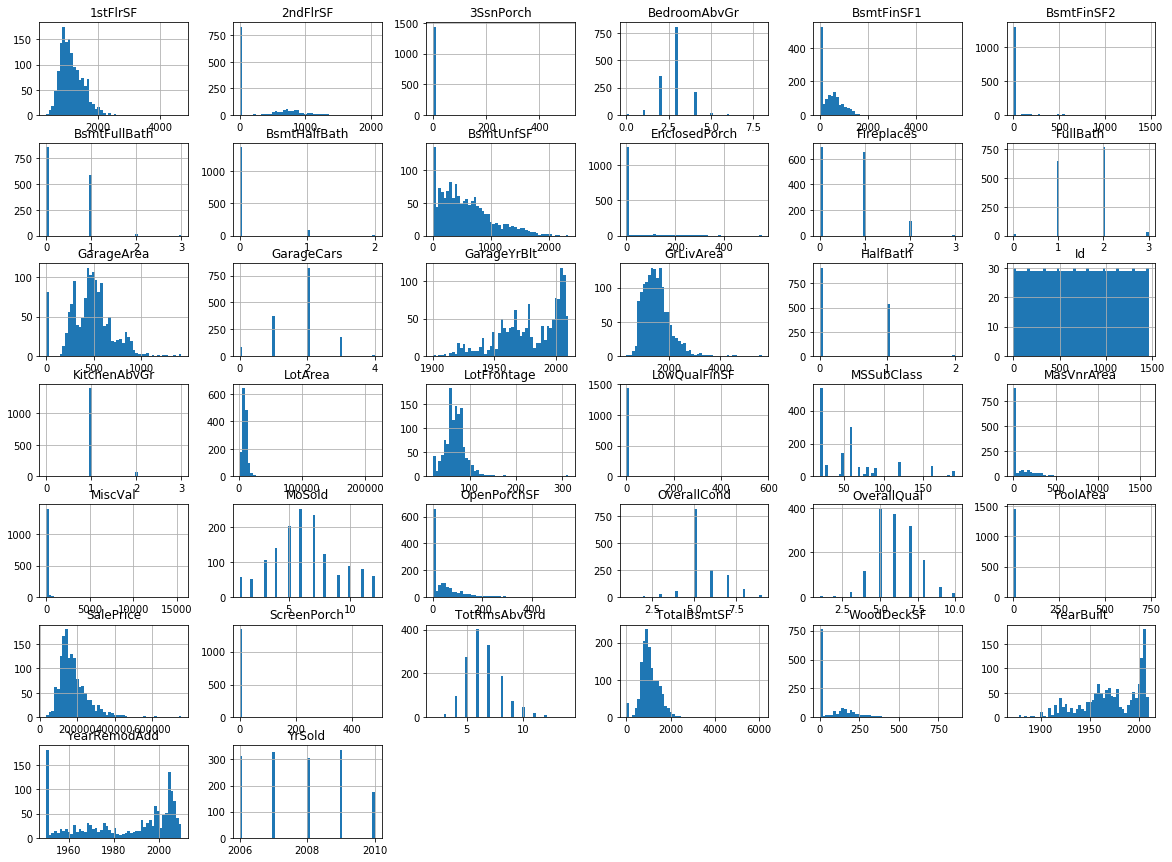

In [4]:
df_train.hist(bins=50, figsize=(20,15))
plt.show()

All the information I want to get from these plots are about odd distributions, not only I see there is a skew in some continuous variables, but also that some features have mostly one value.

One way to remove the skeweness is to simply take the logarithm of the variable. This is what we are going to do now with the target variable

In [5]:
df_train['target'] = np.log1p(df_train.SalePrice)
del df_train['SalePrice']

We will implement a cleaning procedure that follows the documentation shortly but, before even creating the evaluation environment, we want to remove 2 outliers that the documentation recommends to remove. See this step as following the instructions that came with the data.

In [6]:
df_train = df_train[df_train.GrLivArea < 4500].reset_index(drop=True)

Now, since we want to evaluate our model in order to be able to say how good or bad it can be in certain situations, we need to create our test set (not the test set provided by kaggle, that one will arrive in a month after we are done). Every insight and every decision will come from something we will do on the train set, leaving the evaluation of our choices as pure as possible.

If we were doing the data exploration phase before this step, we would have used information coming from both sets to take decisions, a luxury that in a realistic situation we won't have.

How to split the data? Giving the size of the training set, it makes sense to use a 80-20 split. A random split will do the job just fine but we can also use some knowledge of the problem. Since all that matters for a house is *location, location, location* , we can make the split in order to correctly represent the distribution of the houses across the various Neighborhoods (i.e. we can *stratify* the split).

In [7]:
def make_test(train, test_size, random_state, strat_feat=None):
    if strat_feat:
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        for train_index, test_index in split.split(train, train[strat_feat]):
            train_set = train.loc[train_index]
            test_set = train.loc[test_index]
            
    return train_set, test_set

In [8]:
train_set, test_set = make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

And we see that the proportion of houses per Neighborhood is approximatively preserved

In [9]:
train_set.Neighborhood.value_counts(normalize=True)

NAmes      0.154374
CollgCr    0.102916
OldTown    0.077187
Edwards    0.066895
Somerst    0.059177
Gilbert    0.054031
NridgHt    0.053173
Sawyer     0.050600
NWAmes     0.049743
SawyerW    0.040309
BrkSide    0.039451
Crawfor    0.035163
Mitchel    0.033448
NoRidge    0.028302
Timber     0.025729
IDOTRR     0.025729
ClearCr    0.018868
StoneBr    0.017153
SWISU      0.017153
MeadowV    0.012007
Blmngtn    0.012007
BrDale     0.011149
Veenker    0.007719
NPkVill    0.006003
Blueste    0.001715
Name: Neighborhood, dtype: float64

In [10]:
df_train.Neighborhood.value_counts(normalize=True)

NAmes      0.154321
CollgCr    0.102881
OldTown    0.077503
Edwards    0.067215
Somerst    0.058985
Gilbert    0.054184
NridgHt    0.052812
Sawyer     0.050754
NWAmes     0.050069
SawyerW    0.040466
BrkSide    0.039781
Crawfor    0.034979
Mitchel    0.033608
NoRidge    0.028121
Timber     0.026063
IDOTRR     0.025377
ClearCr    0.019204
StoneBr    0.017147
SWISU      0.017147
MeadowV    0.011660
Blmngtn    0.011660
BrDale     0.010974
Veenker    0.007545
NPkVill    0.006173
Blueste    0.001372
Name: Neighborhood, dtype: float64

Before getting insights from the data, let's take the final step of the instructions that came with the data (i.e. the data description) and have a general cleaning

In [11]:
class general_cleaner(BaseEstimator, TransformerMixin):
    '''
    This class applies what we know from the documetation.
    It cleans some known missing values
    If flags the missing values

    This process is supposed to happen as first step of any pipeline
    '''
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #LotFrontage
        X.loc[X.LotFrontage.isnull(), 'LotFrontage'] = 0
        #Alley
        X.loc[X.Alley.isnull(), 'Alley'] = "NoAlley"
        #MSSubClass
        X['MSSubClass'] = X['MSSubClass'].astype(str)
        #MissingBasement
        fil = ((X.BsmtQual.isnull()) & (X.BsmtCond.isnull()) & (X.BsmtExposure.isnull()) &
              (X.BsmtFinType1.isnull()) & (X.BsmtFinType2.isnull()))
        fil1 = ((X.BsmtQual.notnull()) | (X.BsmtCond.notnull()) | (X.BsmtExposure.notnull()) |
              (X.BsmtFinType1.notnull()) | (X.BsmtFinType2.notnull()))
        X.loc[fil1, 'MisBsm'] = 0
        X.loc[fil, 'MisBsm'] = 1 # made explicit for safety
        #BsmtQual
        X.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
        #BsmtCond
        X.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
        #BsmtExposure
        X.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
        #BsmtFinType1
        X.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
        #BsmtFinType2
        X.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
        #BsmtFinSF1
        X.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
        #BsmtFinSF2
        X.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
        #BsmtUnfSF
        X.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
        #TotalBsmtSF
        X.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
        #BsmtFullBath
        X.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
        #BsmtHalfBath
        X.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
        #FireplaceQu
        X.loc[(X.Fireplaces == 0) & (X.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
        #MisGarage
        fil = ((X.GarageYrBlt.isnull()) & (X.GarageType.isnull()) & (X.GarageFinish.isnull()) &
              (X.GarageQual.isnull()) & (X.GarageCond.isnull()))
        fil1 = ((X.GarageYrBlt.notnull()) | (X.GarageType.notnull()) | (X.GarageFinish.notnull()) |
              (X.GarageQual.notnull()) | (X.GarageCond.notnull()))
        X.loc[fil1, 'MisGarage'] = 0
        X.loc[fil, 'MisGarage'] = 1
        #GarageYrBlt
        X.loc[X.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
        X.loc[fil, 'GarageYrBlt'] = X['YearBuilt']  # if no garage, use the age of the building
        #GarageType
        X.loc[fil, 'GarageType'] = "NoGrg" #missing garage
        #GarageFinish
        X.loc[fil, 'GarageFinish'] = "NoGrg" #missing
        #GarageQual
        X.loc[fil, 'GarageQual'] = "NoGrg" #missing
        #GarageCond
        X.loc[fil, 'GarageCond'] = "NoGrg" #missing
        #Fence
        X.loc[X.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
        #Pool
        fil = ((X.PoolArea == 0) & (X.PoolQC.isnull()))
        X.loc[fil, 'PoolQC'] = 'NoPool' 
        
        del X['Id']
        del X['MiscFeature']  # we already know it doesn't matter
        
        return X

Why a class? Because we want to be able to reproduce every step on unseen data and a class makes easier to have a very clear set of steps to follow. More explanation on this and on the use of Pipelines (that will come later) can be found in this other notebook https://www.kaggle.com/lucabasa/understand-and-use-a-pipeline

To use this class and clean our data, we can simply do

In [12]:
train_cleaned = train_set.copy()  # I want to work on train_set again later from scratch

train_cleaned = general_cleaner().fit_transform(train_cleaned)

mis_cols = exp.list_missing(train_cleaned)

Column MasVnrType: 0.69% missing
Column MasVnrArea: 0.69% missing
Column BsmtFinType2: 0.09% missing
Column Electrical: 0.09% missing


We see that most of the missing values were actually very well explained by the documentation, we will deal with the remaining ones later on.

Please note that we don't know what is going to be missing in the future, thus, even if there were no missing values remaining in our data, we should implement procedures to clean the data anyway (or, in alternative, throw appropriate errors so that the team maintaing the model will know quickly what to do).

# Get insights from the data

This phase is tricky because it is easy to go too deep into the rabbit hole. We want to have a comprehensive understanding of the data but at the same time we don't want to spend too much time on it. While in this dataset the number of features is fairly limited, in other cases a slow approach can cost us weeks of work and, at this stage, we don't know if this work is worth weeks of our time.

We will thus focus on the following:

* Correlation with the target
* Univariate and bivariate analysis of the interesting features
* Interesting segmentations with categorical features

Once again, please note how we don't use the full training set but only what we have created in the previous section.

## Numerical features

To first identify what can be interesting, we can look the correlations with the target. This is not by any means enough or necessary to make a feature interesting but, in absence of other knowledge, it is a good first step.

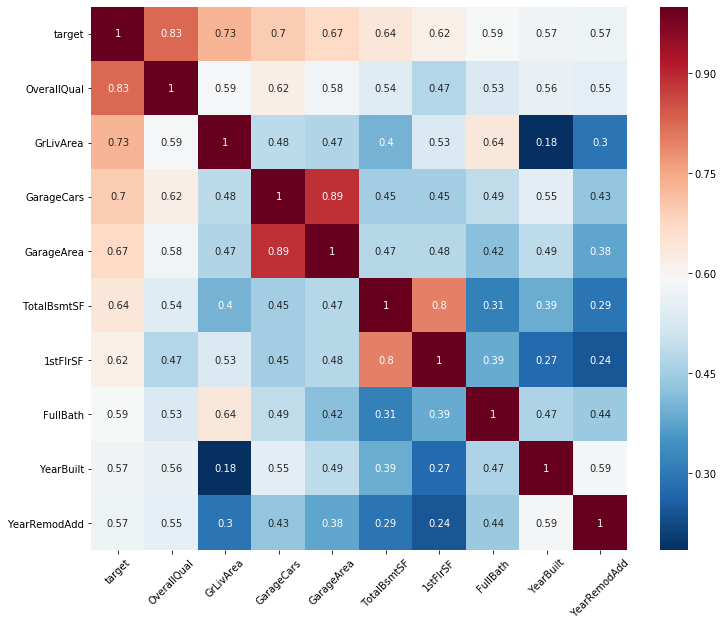

In [13]:
high_corr = exp.plot_correlations(train_cleaned, 'target', limit=10, annot=True)

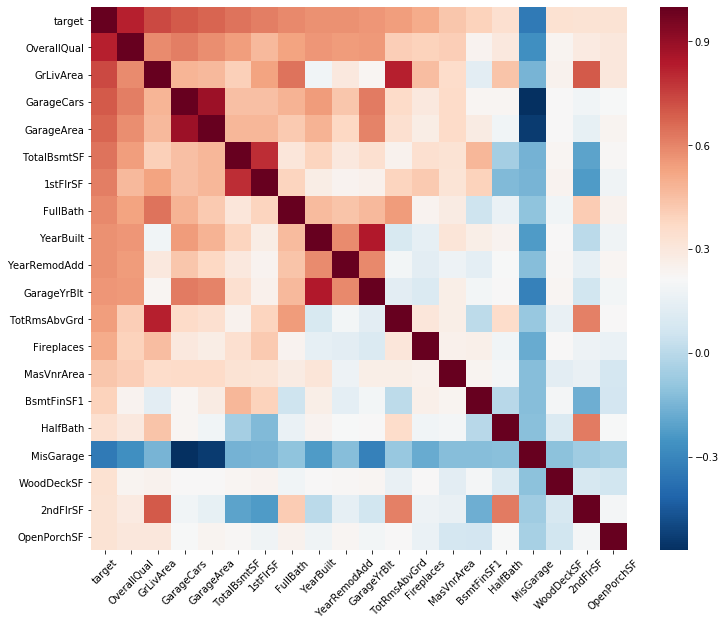

In [14]:
high_corr = exp.plot_correlations(train_cleaned, 'target', limit=20)

Nothing particularly shocking here:

* Overall quality and price are very correlated
* GarageCars and GarageArea are very correlated
* Other fairly expected things

Let's have a look at some distributions, starting with the target variable.

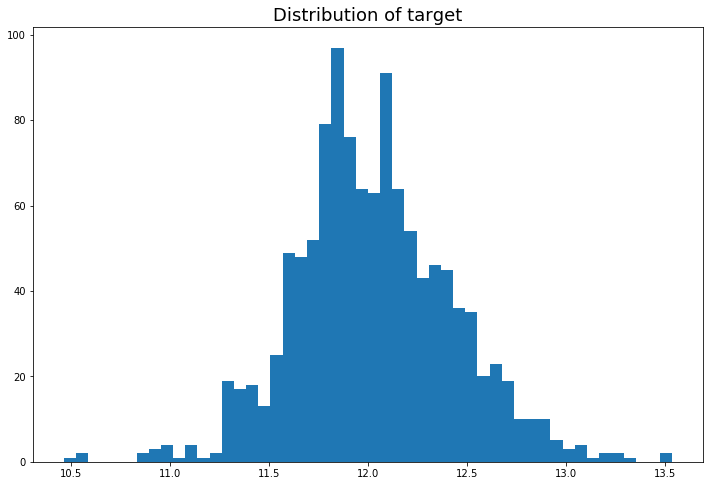

In [15]:
exp.plot_distribution(train_cleaned, 'target')

Yes, we removed the skewness with that logarithm transformation in the previous section.

Let's continue by looking at the numerical features most correlated with the target.

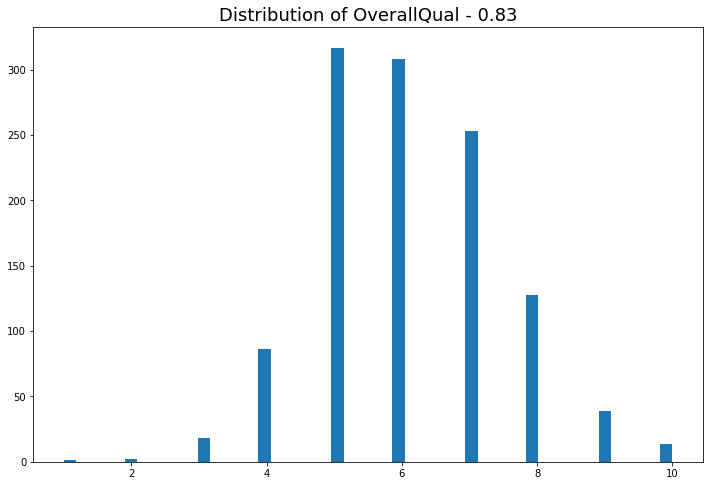

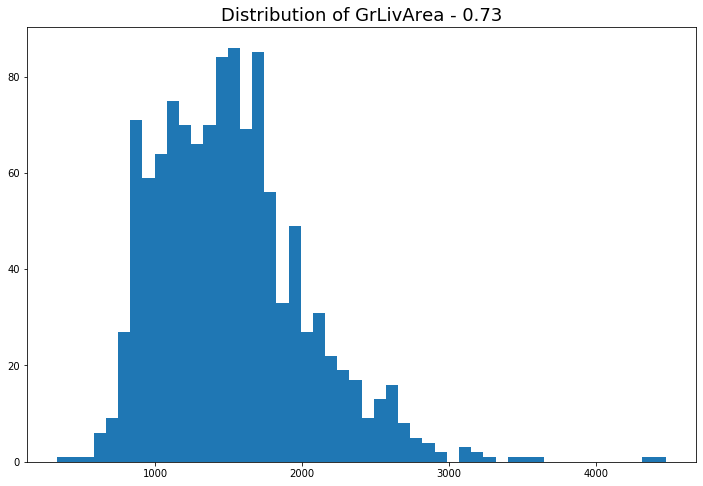

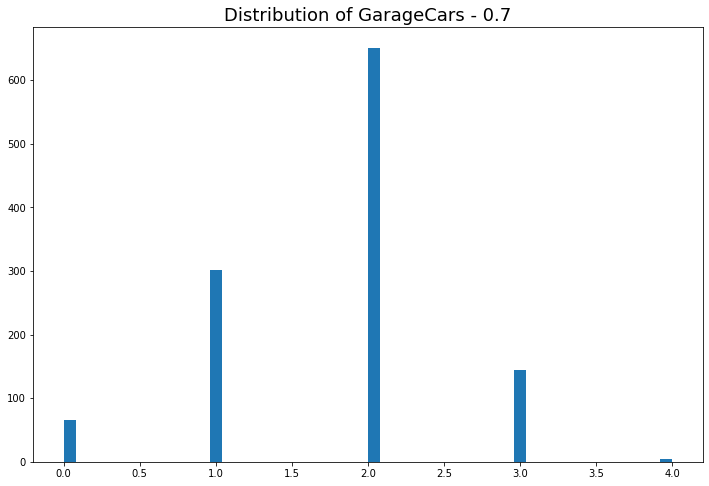

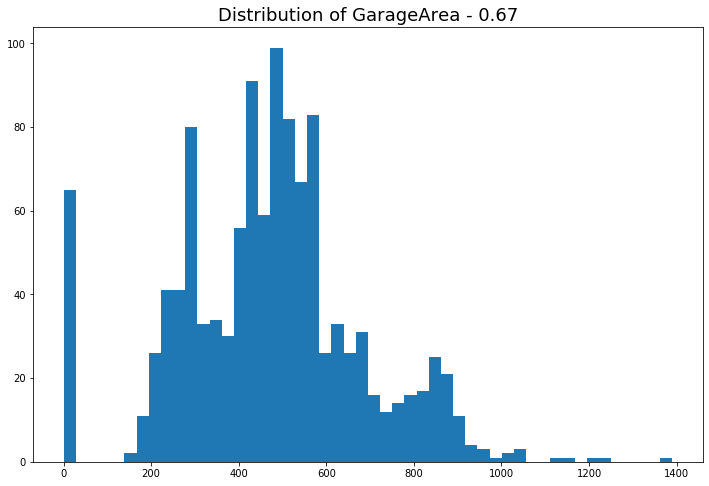

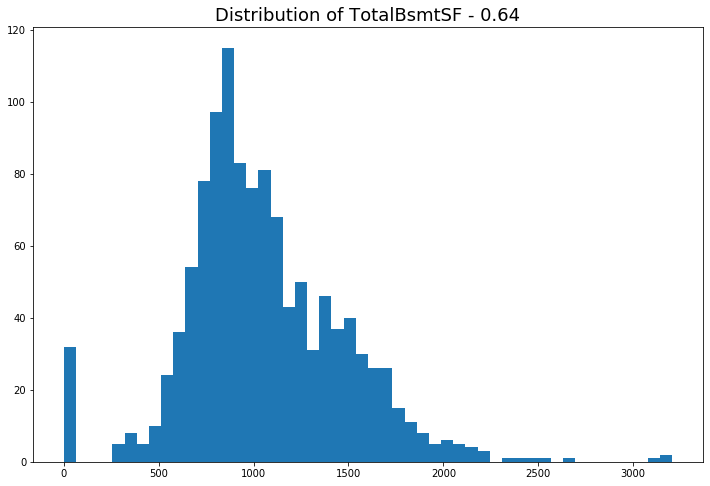

In [16]:
for col in high_corr[1:6].index:
    exp.plot_distribution(train_cleaned, col, correlation=high_corr)

We see, for example, that the negative skew is also present in GrLivArea, a feature that we all expect playing a big role in determining the final price. 

Let's try to get more insights with a bivariate analysis

              OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
OverallQual      1.000000   0.587055    0.618582    0.577956     0.541684   
GrLivArea        0.587055   1.000000    0.482516    0.471170     0.399067   
GarageCars       0.618582   0.482516    1.000000    0.889179     0.449308   
GarageArea       0.577956   0.471170    0.889179    1.000000     0.474743   
TotalBsmtSF      0.541684   0.399067    0.449308    0.474743     1.000000   
1stFlrSF         0.471802   0.530118    0.450187    0.476417     0.796268   
FullBath         0.531866   0.638428    0.488032    0.423072     0.311910   
YearBuilt        0.562561   0.184469    0.548583    0.486097     0.389798   
YearRemodAdd     0.551677   0.295764    0.431481    0.378194     0.294774   
GarageYrBlt      0.555664   0.230821    0.620629    0.607188     0.339224   
TotRmsAbvGrd     0.410755   0.824105    0.367417    0.339575     0.250345   
target           0.826131   0.730448    0.696102    0.673793     0.641253   

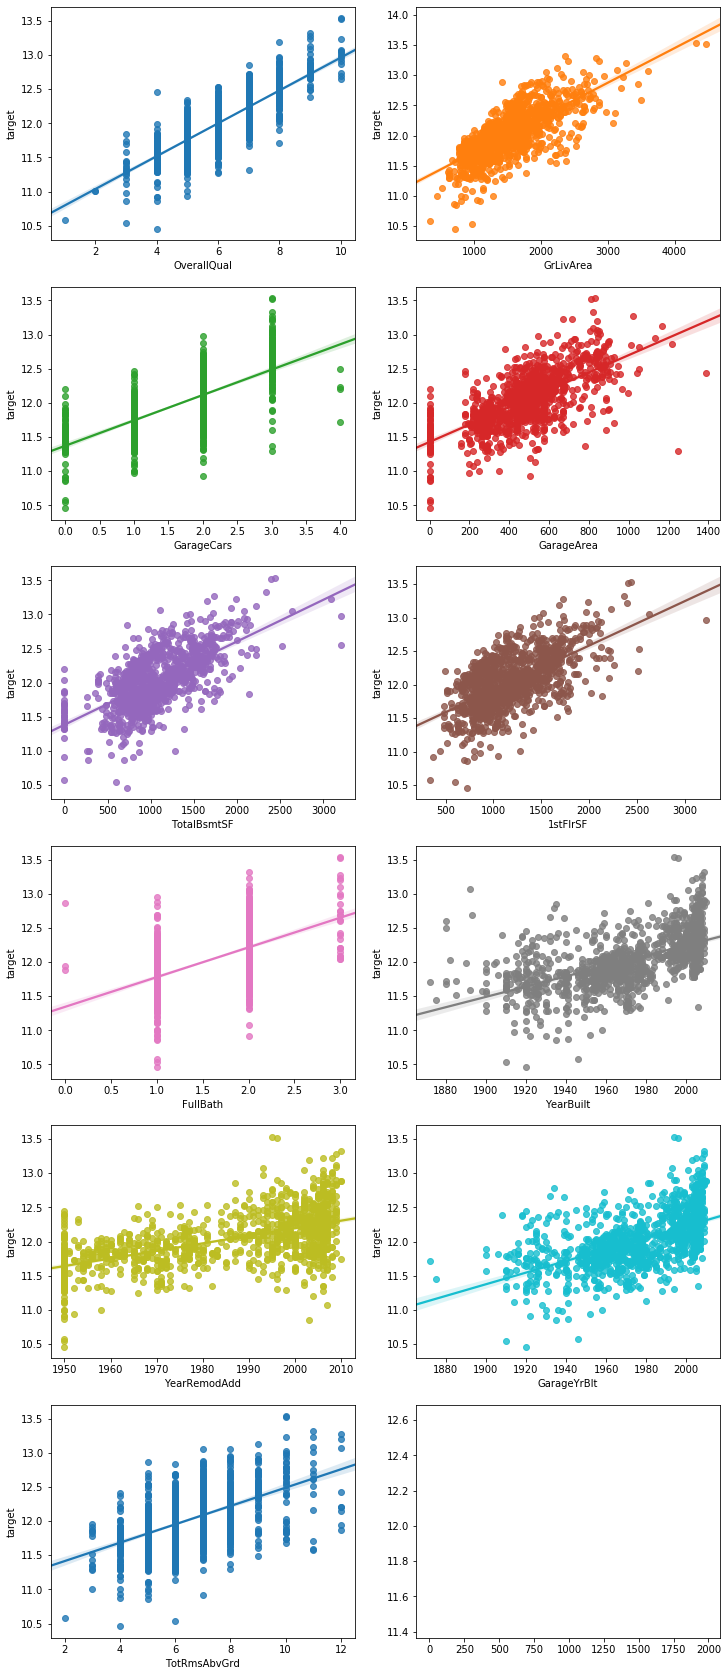

In [17]:
exp.corr_target(train_cleaned, 'target', list(high_corr[1:12].index))

The discrete values of GarageCars and OverallQual invite in using some estimator to see if the patter is clear as it looks.

             OverallQual  GarageCars    target
OverallQual     1.000000    0.618582  0.826131
GarageCars      0.618582    1.000000  0.696102
target          0.826131    0.696102  1.000000


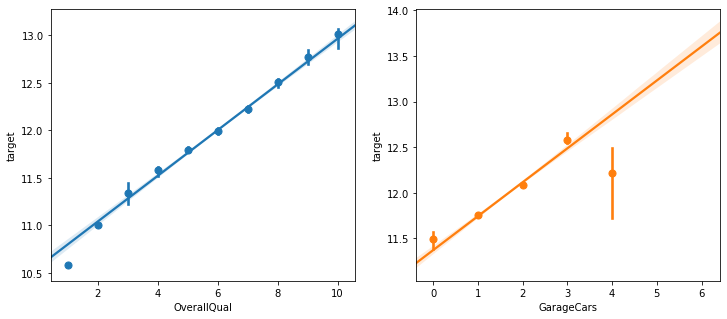

In [18]:
exp.corr_target(train_cleaned, 'target',
                [col for col in high_corr.index if 'Qual' in col or 'Car' in col],
                x_estimator=np.median)

Yes, it is very clear indeed. Let's move on to the categorical features.

## Categorical features

In this dataset we don't have many features and, thanks to the function in the `explore_data` utility script, we can quickly shuffle through all of them to find the interesting one. If this was not possible, one approach would be to find the features whose cateogories exhibit a significantly different distribution of the target variable. In other words, for example, if the distribution of prices for houses withouth a Fence is significantly different than the ones with a Fence, the next function will catch it and tell us.

In [19]:
exp.find_cats(train_cleaned, 'target', thrs=0.3, critical=0.05)

Column MSSubClass throws the following error: Data passed to ks_2samp must not be empty
Column MSZoning throws the following error: Data passed to ks_2samp must not be empty
Column Street throws the following error: Data passed to ks_2samp must not be empty
Column Alley throws the following error: Data passed to ks_2samp must not be empty
Column LandContour throws the following error: Data passed to ks_2samp must not be empty
Column Utilities throws the following error: Data passed to ks_2samp must not be empty
Column LotConfig throws the following error: Data passed to ks_2samp must not be empty
Column LandSlope throws the following error: Data passed to ks_2samp must not be empty
Column Condition1 throws the following error: Data passed to ks_2samp must not be empty
Column Condition2 throws the following error: Data passed to ks_2samp must not be empty
Column BldgType throws the following error: Data passed to ks_2samp must not be empty
Column RoofStyle throws the following error: Da

['LotShape',
 'HouseStyle',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'KitchenQual']

We can start from these to see if we get some insight

,count,mean,max,min,median,std
BsmtQual,,,,,,
Ex,92,12.661743,13.534474,11.724005,12.683831,0.343460
Fa,22,11.726709,12.239996,11.198228,11.734057,0.262231
Gd,496,12.184570,13.195616,11.289794,12.178193,0.284848
NoBsmt,32,11.532958,12.198549,10.579005,11.552167,0.301022
TA,524,11.807075,13.071072,10.460271,11.813037,0.300840


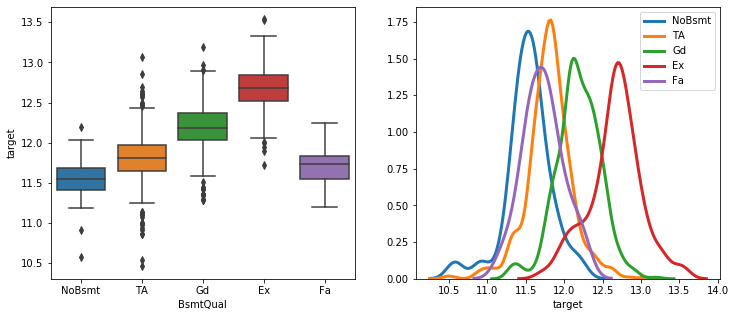

In [20]:
exp.segm_target(train_cleaned, 'BsmtQual', 'target')

It seems there is a very clear relation between the quality of the basement and the sale price. Moreover, it invites in recoding `BsmtQual` into an ordinal feature.

The same holds for `KitchenQual`

,count,mean,max,min,median,std
KitchenQual,,,,,,
Ex,81,12.675378,13.534474,11.429555,12.691584,0.376239
Fa,31,11.465739,12.069686,10.579005,11.594515,0.371069
Gd,463,12.224121,12.991756,11.277216,12.225880,0.282112
TA,591,11.811277,12.791359,10.460271,11.820418,0.277610


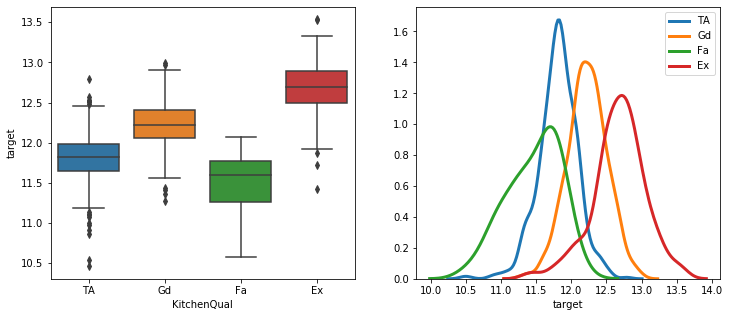

In [21]:
exp.segm_target(train_cleaned, 'KitchenQual', 'target')

Or of `ExterQual`

,count,mean,max,min,median,std
ExterQual,,,,,,
Ex,41,12.804920,13.534474,12.081082,12.823631,0.319093
Fa,11,11.220981,11.711785,10.579005,11.314487,0.329191
Gd,391,12.310935,13.521141,10.859018,12.314932,0.288026
TA,723,11.840067,12.850557,10.460271,11.845110,0.290072


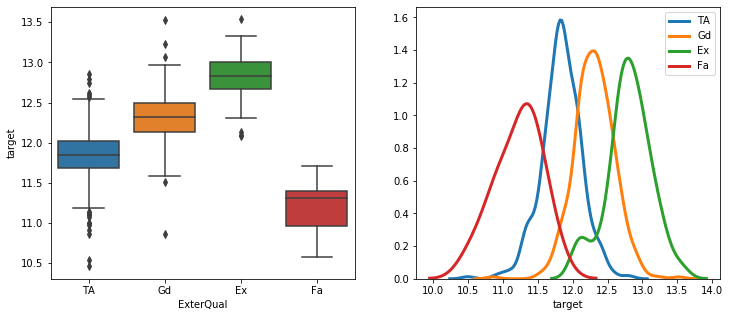

In [22]:
exp.segm_target(train_cleaned, 'ExterQual', 'target')

,count,mean,max,min,median,std
LotShape,,,,,,
IR1,370,12.185910,13.534474,10.859018,12.157409,0.373096
IR2,35,12.333127,13.195616,11.884496,12.310437,0.344046
IR3,7,12.136881,12.523530,11.198228,12.165985,0.462872
Reg,754,11.932324,13.275829,10.460271,11.884496,0.383705


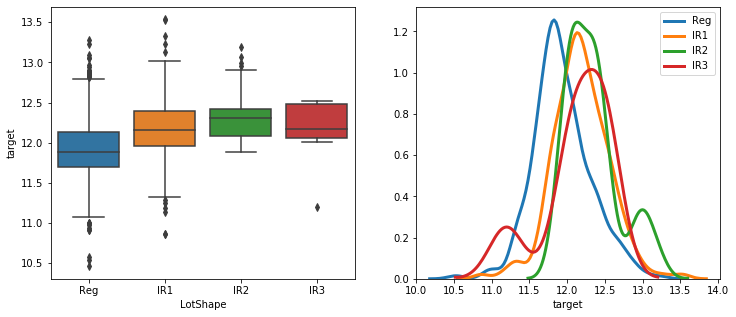

In [23]:
exp.segm_target(train_cleaned, 'LotShape', 'target')

Here it looks it makes a difference only in having a regular vs irregular lot shape.

/home/lucabasa/Git/kaggle_competitions/houseprice/hp/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/lucabasa/Git/kaggle_competitions/houseprice/hp/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,count,mean,max,min,median,std
MasVnrType,,,,,,
BrkCmn,11,11.885626,12.531776,11.607335,11.842236,0.263243
BrkFace,352,12.173350,13.534474,11.320566,12.125406,0.347471
None,697,11.893713,13.521141,10.460271,11.867104,0.364996
Stone,98,12.429558,13.323929,11.686887,12.425865,0.377575


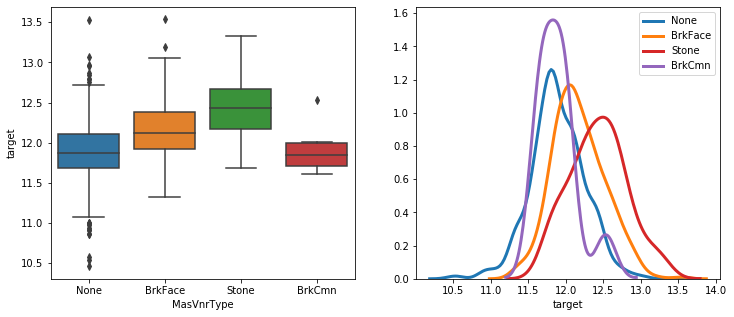

In [24]:
exp.segm_target(train_cleaned, 'MasVnrType', 'target')

The other features found above do not show anything in particular on this kind of plots, so we won't display them. We can have a quick look at other features not found by that function, for example

,count,mean,max,min,median,std
CentralAir,,,,,,
N,80,11.506346,12.491176,10.460271,11.502834,0.381048
Y,1086,12.064336,13.534474,10.859018,12.043265,0.374701


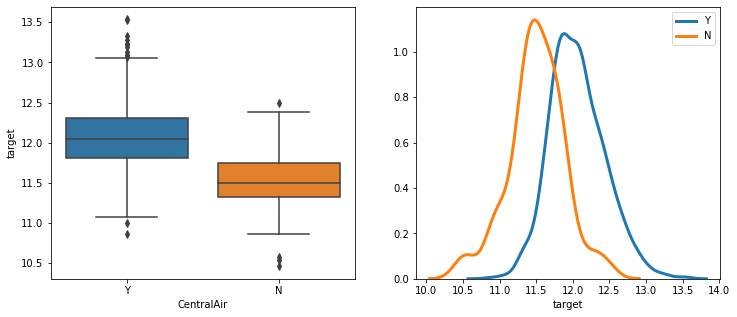

In [25]:
exp.segm_target(train_cleaned, 'CentralAir', 'target')

,count,mean,max,min,median,std
GarageFinish,,,,,,
Fin,278,12.318569,13.534474,11.320566,12.286128,0.370954
NoGrg,65,11.468998,12.208575,10.460271,11.492733,0.351975
RFn,336,12.170259,13.275829,11.133143,12.154785,0.294461
Unf,487,11.833927,13.071072,10.933000,11.813037,0.297419


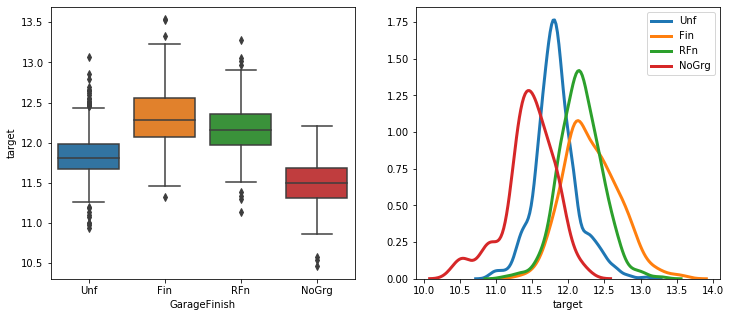

In [26]:
exp.segm_target(train_cleaned, 'GarageFinish', 'target')

Another way of looking at these features is to combine them in a plot together with another numerical feature. We know that `GrLivArea` is going to be important and our function told us that `HouseStyle` has interesting categories in it. We can combine them like this

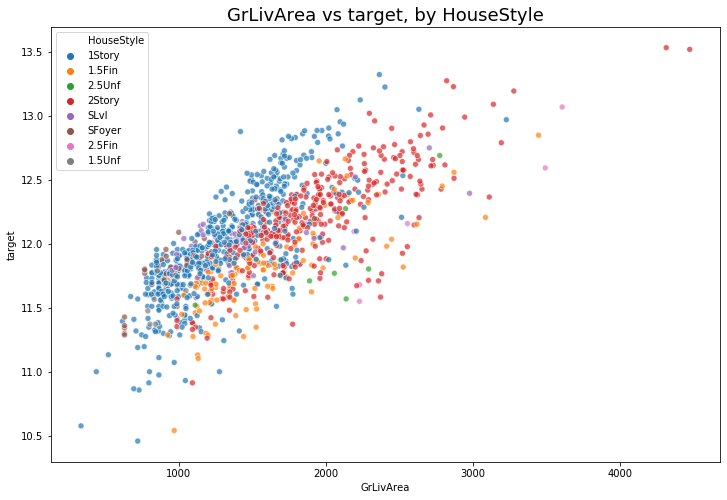

In [27]:
exp.plot_bivariate(train_cleaned, 'GrLivArea', 'target', hue='HouseStyle', alpha=0.7)

Or use this plot to just investigate further the features we have analyzed before

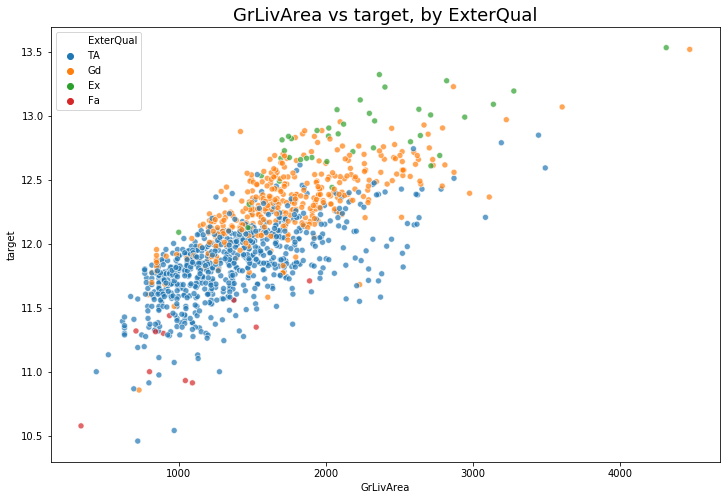

In [28]:
exp.plot_bivariate(train_cleaned, 'GrLivArea', 'target', hue='ExterQual', alpha=0.7)

As mentioned before, it is easy to go too deep in the rabbit hole in this phase. I have been writing this section for an hour already and I feel confident enough about the data to run the first models.

# First models, validation, and error analysis.

This section has multiple goals, the main one is to bridge to the next section about feature engineering. We want to implement a system of evaluating, selecting, and tuning our models that is robust enough to the data processing phase. If we do this part correctly, we will be able to quickly iterate between the processing and modeling phase, being confident that we can correctly assess the validity of our actions. 

As explained already in this notebook https://www.kaggle.com/lucabasa/understand-and-use-a-pipeline, we need different transformations for numeric and categorical features. We will use the insights gained in the previous section to make a few new custom transformers.

In [29]:
class tr_numeric(BaseEstimator, TransformerMixin):
    def __init__(self, SF_room=True, bedroom=True, bath=True, lot=True, service=True):
        self.columns = []  # useful to well behave with FeatureUnion
        

    def fit(self, X, y=None):
        return self
    

    def remove_skew(self, X, column):
        X[column] = np.log1p(X[column])
        return X

    def transform(self, X, y=None):
        for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
            X = self.remove_skew(X, col)

        self.columns = X.columns
        return X
    

    def get_features_name(self):
        return self.columns
    
    
class make_ordinal(BaseEstimator, TransformerMixin):
    '''
    Transforms ordinal features in order to have them as numeric (preserving the order)
    If unsure about converting or not a feature (maybe making dummies is better), make use of
    extra_cols and unsure_conversion
    '''
    def __init__(self, cols, extra_cols=None, include_extra=True):
        self.cols = cols
        self.extra_cols = extra_cols
        self.mapping = {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        self.include_extra = include_extra
    

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if self.extra_cols:
            if self.include_extra:
                self.cols += self.extra_cols
            else:
                for col in self.extra_cols:
                    del X[col]
        
        for col in self.cols:
            X.loc[:, col] = X[col].map(self.mapping).fillna(0)
        return X


class recode_cat(BaseEstimator, TransformerMixin):        
    '''
    Recodes some categorical variables according to the insights gained from the
    data exploration phase.
    '''
    def fit(self, X, y=None):
        return self
    
    
    def tr_GrgType(self, data):
        data['GarageType'] = data['GarageType'].map({'Basment': 'Attchd',
                                                  'CarPort': 'Detchd', 
                                                  '2Types': 'Attchd' }).fillna(data['GarageType'])
        return data
    
    
    def tr_LotShape(self, data):
        fil = (data.LotShape != 'Reg')
        data['LotShape'] = 1
        data.loc[fil, 'LotShape'] = 0
        return data
    
    
    def tr_LandCont(self, data):
        fil = (data.LandContour == 'HLS') | (data.LandContour == 'Low')
        data['LandContour'] = 0
        data.loc[fil, 'LandContour'] = 1
        return data
    
    
    def tr_MSZoning(self, data):
        data['MSZoning'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                 'C (all)': 'RM', # commercial and medium density
                                                 'FV': 'RM'}).fillna(data['MSZoning'])
        return data
    
    
    def tr_Alley(self, data):
        fil = (data.Alley != 'NoAlley')
        data['Alley'] = 0
        data.loc[fil, 'Alley'] = 1
        return data
    
    
    def tr_LotConfig(self, data):
        data['LotConfig'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                   'FR2': 'Corner'}).fillna(data['LotConfig'])
        return data
    
    
    def tr_BldgType(self, data):
        data['BldgType'] = data['BldgType'].map({'Twnhs' : 'TwnhsE',
                                                 '2fmCon': 'Duplex'}).fillna(data['BldgType'])
        return data
    
    
    def tr_MasVnrType(self, data):
        data['MasVnrType'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
        return data


    def tr_HouseStyle(self, data):
        data['HouseStyle'] = data['HouseStyle'].map({'1.5Fin': '1.5Unf',
                                                     '2.5Fin': '2Story',
                                                     '2.5Unf': '2Story',
                                                     'SLvl': 'SFoyer'}).fillna(data['HouseStyle'])
        return data
    
    
    def transform(self, X, y=None):
        X = self.tr_GrgType(X)
        X = self.tr_LotShape(X)
        X = self.tr_LotConfig(X)
        X = self.tr_MSZoning(X)
        X = self.tr_Alley(X)
        X = self.tr_LandCont(X)
        X = self.tr_BldgType(X)
        X = self.tr_MasVnrType(X)
        X = self.tr_HouseStyle(X)
        return X
    

class drop_columns(BaseEstimator, TransformerMixin):
    '''
    Drops columns that are not useful for the model
    '''
    def __init__(self):
        self.columns = []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        to_drop = [col for col in X.columns if 'NoGrg' in col]  # dropping dummies that are redundant
        to_drop += [col for col in X.columns if 'NoBsmt' in col]
        # other not useful columns
        to_drop += [col for col in X.columns if 'MSSubClass' in col]
        to_drop += [col for col in X.columns if 'Neighborhood' in col]  # maybe useful in the future
        to_drop += [col for col in X.columns if 'Condition1' in col]
        to_drop += [col for col in X.columns if 'Condition2' in col]
        to_drop += [col for col in X.columns if 'ExterCond' in col]  # maybe make it ordinal
        to_drop += [col for col in X.columns if 'Exterior1st' in col]
        to_drop += [col for col in X.columns if 'Exterior2nd' in col]
        to_drop += [col for col in X.columns if 'Functional' in col]
        to_drop += [col for col in X.columns if 'Heating_' in col]  # we don't want to drop the dummies of HeatingQC too
        to_drop += [col for col in X.columns if 'PoolQC' in col]
        to_drop += [col for col in X.columns if 'RoofMatl' in col]
        to_drop += [col for col in X.columns if 'RoofStyle' in col]
        to_drop += [col for col in X.columns if 'SaleCondition' in col]
        to_drop += [col for col in X.columns if 'SaleType' in col]
        to_drop += [col for col in X.columns if 'Utilities' in col]
        to_drop += [col for col in X.columns if 'BsmtCond' in col]  # maybe ordinal
        to_drop += [col for col in X.columns if 'Electrical' in col]
        to_drop += [col for col in X.columns if 'Foundation' in col]
        to_drop += [col for col in X.columns if 'LandSlope' in col]
        to_drop += [col for col in X.columns if 'Street' in col]
        to_drop += [col for col in X.columns if 'Fence' in col]
        to_drop += [col for col in X.columns if 'PavedDrive' in col]

        for col in to_drop:
            try:
                del X[col]
            except KeyError:
                pass
            
        self.columns = X.columns
        return X
    
    def get_feature_names(self):
        return list(self.columns)

In [30]:
numeric_pipe = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imputer', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric())])


cat_pipe = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imputer', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual','GarageQual',
                                           'GarageCond', 'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify())])


processing_pipe = dfp.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('gen_cl', general_cleaner()), 
                      ('processing', processing_pipe), 
                      ('scaler', dfp.df_scaler()), 
                      ('dropper', drop_columns())])

tmp = train_set.copy()

full_pipe.fit_transform(tmp).head()

,Alley,LotShape,LandContour,ExterQual,BsmtQual,HeatingQC,KitchenQual,GarageQual,GarageCond,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,BldgType_1Fam,BldgType_Duplex,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,CentralAir_N,CentralAir_Y,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFire,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target,MisBsm,MisGarage
1231,-0.260318,0.739202,-0.24691,-0.691394,-3.956431,-1.195302,-0.766243,0.256754,0.262237,0.523753,-0.523753,1.954017,-0.265908,-1.629470,-2.245318,4.018340,-0.346521,-0.358819,1.015558,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,-0.411714,-0.312935,-0.271413,-1.424279,-0.408861,-0.335552,-0.622973,-0.230862,-0.322749,-0.660273,-0.117954,-0.15102,-0.093008,-0.186025,-0.198030,-2.445820,-0.271413,0.271413,-0.132106,-0.148022,-0.593859,1.063780,-0.114158,-0.529067,-1.236642,-0.264054,1.625961,-0.55952,-0.636254,1.180784,0.378144,0.178389,-1.532470,-0.520843,-0.298452,-1.099477,-0.571568,-0.994151,-0.289380,-1.297802,-2.507078,0.323866,-0.807309,-0.120044,-0.495641,-0.790416,-0.235080,0.795626,-0.775213,-1.098144,4.116721,-0.336957,-0.959872,-0.543172,0.317934,-0.039470,-0.737686,-0.699962,-0.361219,-0.114858,-0.273783,-0.064936,-0.088546,-1.198176,-0.613727,-1.236720,5.952940,-0.242976
1456,-0.260318,0.739202,-0.24691,-0.691394,-0.547664,-0.153656,0.737864,0.256754,0.262237,0.523753,-0.523753,-0.511766,-0.265908,0.613696,0.445371,-0.248859,-0.346521,-0.358819,1.015558,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,-0.411714,-0.312935,3.684427,-1.424279,-0.408861,-0.335552,1.605206,-0.230862,-0.322749,-0.660273,-0.117954,-0.15102,-0.093008,-0.186025,5.049752,-2.445820,-0.271413,0.271413,-0.132106,-0.148022,-0.593859,1.063780,-0.114158,-0.529067,0.808641,-0.264054,-0.615021,-0.55952,-0.636254,1.180784,0.319926,0.153680,-0.805513,0.393770,-0.692632,0.546086,-0.571568,-0.881439,5.992652,-1.297802,0.057797,-0.080602,-0.807309,-0.120044,-0.880038,1.158052,-0.235080,-1.045048,-0.775213,-1.098144,-0.219410,-0.953743,-0.959872,-0.997286,-1.015558,-1.084470,2.128905,-0.699962,1.448993,-0.114858,-0.273783,-0.064936,-0.088546,-0.828482,1.648460,-0.403476,-0.167984,-0.242976
242,-0.260318,0.739202,-0.24691,-0.691394,-0.547664,-0.153656,-0.766243,-1.122854,0.262237,-1.909298,1.909298,1.954017,-0.265908,-1.629470,0.445371,-0.248859,-0.346521,2.786919,-0.984680,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,-0.411714,-0.312935,-0.271413,0.702109,-0.408861,-0.335552,-0.622973,-0.230862,-0.322749,1.514525,-0.117954,-0.15102,-0.093008,-0.186025,-0.198030,0.408861,3.684427,-3.684427,-0.132106,-0.148022,-0.593859,1.063780,-0.114158,-0.529067,0.808641,-0.264054,-0.615021,-0.55952,-0.636254,1.180784,0.174380,-1.130681,-0.805513,-1.435457,-2.335049,-1.680264,-0.571568,-0.994151,-0.289380,-0.077121,-1.222261,-0.694344,0.447417,-0.120044,-0.003745,-0.790416,-0.235080,-1.045048,-0.775213,0.158417,-0.219410,-0.336957,-0.959872,-1.375715,-1.015558,-0.557263,-0.737686,-0.699962,0.883302,-0.114858,-0.273783,-0.064936,-0.088546,-0.828482,-1.367789,-1.869865,-0.167984,-0.242976
93,-0.260318,0.739202,-0.24691,-0.691394,-0.547664,0.887990,-0.766243,0

As you can see, we fill the missing values either with the median or with the mode, we remove the skew from some numerical features, we make some categorical feature ordinal, and we recode some categories accordingly to what we have already seen in the data exploration phase. By also using those insights, we drop some columns to make our model simpler. A few of these columns might be useful later on but for now we can safely drop them.

At the end of this pipeline, we will put a model. We know we need a regressor, but we still don't know what model is going to be good enough for us. We thus need to implement some methods to evaluate the models. At that point, we can simply try some models and focus on the most promising one.

There is no point now to play around with hyperparameters as we still have to try to improve the quality of our data before, which will improve our model far more than a fine tuned parameter

In [31]:
def cv_score(df_train, y_train, kfolds, pipeline, imp_coef=False):
    oof = np.zeros(len(df_train))
    train = df_train.copy()
    
    feat_df = pd.DataFrame()
    
    for n_fold, (train_index, test_index) in enumerate(kfolds.split(train.values)):
            
        trn_data = train.iloc[train_index][:]
        val_data = train.iloc[test_index][:]
        
        trn_target = y_train.iloc[train_index].values.ravel()
        val_target = y_train.iloc[test_index].values.ravel()
        
        pipeline.fit(trn_data, trn_target)

        oof[test_index] = pipeline.predict(val_data).ravel()

        if imp_coef:
            try:
                fold_df = get_coef(pipeline)
            except AttributeError:
                fold_df = get_feature_importance(pipeline)
                
            fold_df['fold'] = n_fold + 1
            feat_df = pd.concat([feat_df, fold_df], axis=0)
       
            
    if imp_coef:
        feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
        feat_df['abs_sco'] = (abs(feat_df['mean']))
        feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
        del feat_df['abs_sco']
        return oof, feat_df
    else:    
        return oof


def get_coef(pipe):
    imp = pipe.steps[-1][1].coef_.tolist()
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result['abs_res'] = abs(result['score'])
    result = result.sort_values(by=['abs_res'],ascending=False)
    del result['abs_res']
    return result


def get_feature_importance(pipe):
    imp = pipe.steps[-1][1].feature_importances_.tolist() #it's a pipeline
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_predictions(data, true_label, pred_label, feature=None, hue=None, legend=False):
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    tmp['Residual'] = tmp['True Label'] - tmp['Prediction']
    
    diag = False
    alpha = 0.7
    label = ''
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    if feature is None:
        feature = 'True Label'
        diag = True
    else:
        legend = 'full'
        sns.scatterplot(x=feature, y='True Label', data=tmp, ax=ax[0], label='True',
                         hue=hue, legend=legend, alpha=alpha)
        label = 'Predicted'
        alpha = 0.4

    sns.scatterplot(x=feature, y='Prediction', data=tmp, ax=ax[0], label=label,
                         hue=hue, legend=legend, alpha=alpha)
    if diag:
        ax[0] = _plot_diagonal(ax[0])
    
    sns.scatterplot(x=feature, y='Residual', data=tmp, ax=ax[1], 
                    hue=hue, legend=legend, alpha=0.7)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    ax[0].set_title(f'{feature} vs Predictions')
    ax[1].set_title(f'{feature} vs Residuals')

In [32]:
models = [('lasso', Lasso(alpha=0.01)), ('ridge', Ridge()), ('sgd', SGDRegressor()), 
          ('forest', RandomForestRegressor(n_estimators=200)), ('xtree', ExtraTreesRegressor(n_estimators=200)), 
          ('svr', SVR(gamma='auto')), 
          ('kneig', KNeighborsRegressor(n_neighbors=10)),
          ('nn', MLPRegressor(hidden_layer_sizes=(100, 50, 20), max_iter=400)),
          ('xgb', xgb.XGBRegressor(n_estimators=200, objective='reg:squarederror')), 
          ('lgb', lgb.LGBMRegressor(n_estimators=200))]

mod_name = []
rmse_train = []
rmse_test = []
mae_train = []
mae_test = []

folds = KFold(5, shuffle=True, random_state=541)

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target']
del test_set['target']

warnings.filterwarnings("ignore", 
                        message="The dummies in this set do not match the ones in the train set, we corrected the issue.")

for model in models:
    
    train = train_set.copy()
    test = test_set.copy()
    print(model[0])
    mod_name.append(model[0])
    
    pipe = [('gen_cl', general_cleaner()),
            ('processing', processing_pipe),
            ('scl', dfp.df_scaler()),
            ('dropper', drop_columns())] + [model]
    
    model_pipe = Pipeline(pipe)
            
    inf_preds = cv_score(train, y, folds, model_pipe)
    
    model_pipe.fit(train, y)  # refit on full train set
    
    preds = model_pipe.predict(test)
    
    rmse_train.append(mean_squared_error(y, inf_preds))
    rmse_test.append(mean_squared_error(y_test, preds))
    mae_train.append(mean_absolute_error(np.expm1(y), np.expm1(inf_preds)))
    mae_test.append(mean_absolute_error(np.expm1(y_test), np.expm1(preds)))
    
    print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, inf_preds)), 4)}')
    print(f'\tTrain set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(inf_preds)), 2)}')
    print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
    print(f'\tTest set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
    
    print('_'*40)
    print('\n')
    
results = pd.DataFrame({'model_name': mod_name, 
                        'rmse_train': rmse_train, 'rmse_test': rmse_test,
                        'mae_train': mae_train, 'mae_test': mae_test})

results

lasso
	Train set RMSE: 0.1357
	Train set MAE: 18201.05
	Test set RMSE: 0.1414
	Test set MAE: 17177.23
________________________________________


ridge
	Train set RMSE: 0.1736
	Train set MAE: 22744.17
	Test set RMSE: 0.1441
	Test set MAE: 17141.26
________________________________________


sgd
	Train set RMSE: 0.2234
	Train set MAE: 27460.04
	Test set RMSE: 0.1555
	Test set MAE: 19185.23
________________________________________


forest
	Train set RMSE: 0.1499
	Train set MAE: 19452.8
	Test set RMSE: 0.1628
	Test set MAE: 19297.92
________________________________________


xtree
	Train set RMSE: 0.1803
	Train set MAE: 23259.51
	Test set RMSE: 0.1781
	Test set MAE: 21585.3
________________________________________


svr
	Train set RMSE: 0.3538
	Train set MAE: 48779.12
	Test set RMSE: 0.3283
	Test set MAE: 42957.59
________________________________________


kneig
	Train set RMSE: 0.3003
	Train set MAE: 39693.98
	Test set RMSE: 0.302
	Test set MAE: 40885.84
__________________________________

/home/lucabasa/Git/kaggle_competitions/houseprice/hp/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


	Train set RMSE: 0.1463
	Train set MAE: 19263.11
	Test set RMSE: 0.1512
	Test set MAE: 17771.68
________________________________________


lgb
	Train set RMSE: 0.1488
	Train set MAE: 19300.52
	Test set RMSE: 0.1544
	Test set MAE: 17652.14
________________________________________




,model_name,rmse_train,rmse_test,mae_train,mae_test
0,lasso,0.018417,0.019999,1.820105e+04,17177.225144
1,ridge,0.030136,0.020751,2.274417e+04,17141.262483
2,sgd,0.049890,0.024167,2.746004e+04,19185.226949
3,forest,0.022461,0.026503,1.945280e+04,19297.919206
4,xtree,0.032501,0.031718,2.325951e+04,21585.301809
5,svr,0.125159,0.107793,4.877912e+04,42957.594561
6,kneig,0.090202,0.091217,3.969398e+04,40885.841872
7,nn,7.583345,2.311094,5.856580e+17,155404.755127
8,xgb,0.021400,0.022856,1.926311e+04,17771.682631
9,lgb,0.022145,0.023838,1.930052e+04,17652.136542


We will continue with the top5: Lasso, RandomForest, XGBoost, LGBoost, Ridge. We will have these results as baseline, being them the one we obtained by simply looking at the data.

We can investigate each of these models by looking at their predictions and at how those predictions are made. For example

In [33]:
lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('processing', processing_pipe),
                       ('scl', dfp.df_scaler()), 
                       ('dropper', drop_columns()), 
                       ('lasso', Lasso(alpha=0.01))])

lasso_oof, coefs = cv_score(train_set, y, folds, lasso_pipe, imp_coef=True)

coefs  

,mean,std
feat,,
GrLivArea,0.118775,0.005420
OverallQual,0.097193,0.003105
YearBuilt,0.043166,0.003920
LotArea,0.036862,0.002173
BsmtFinSF1,0.033600,0.002081
...,...,...
HouseStyle_SFoyer,0.000000,0.000000
BsmtFinSF2,0.000000,0.000000
BsmtExposure_No,0.000000,0.000000


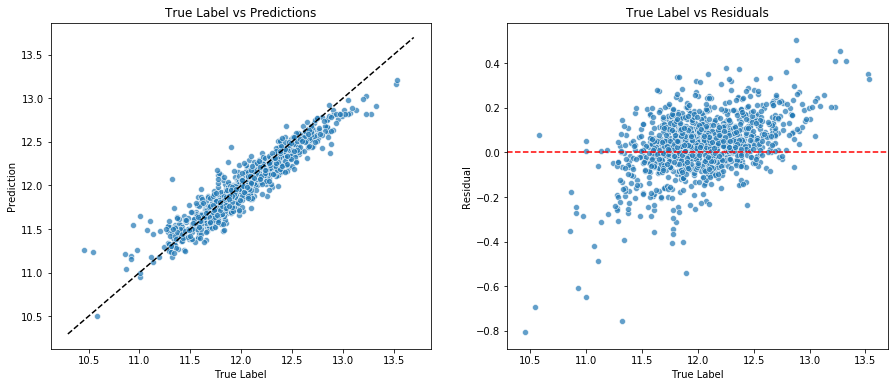

In [34]:
plot_predictions(train_set, y, lasso_oof)

This residual plot is fairly problematic and we will address it later on. 

We also notice that quite a few features do not matter for our predictions

In [35]:
coefs[coefs['mean'] == 0].sample(10)

,mean,std
feat,,
LowQualFinSF,0.0,0.0
3SsnPorch,0.0,0.0
EnclosedPorch,0.0,0.0
LotConfig_Corner,0.0,0.0
BsmtExposure_No,0.0,0.0
PoolArea,0.0,0.0
HouseStyle_2Story,0.0,0.0
BsmtFinType2_GLQ,0.0,0.0
FullBath,0.0,0.0


In [36]:
forest_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('processing', processing_pipe),
                       ('scl', dfp.df_scaler()), 
                       ('dropper', drop_columns()), 
                       ('forest', RandomForestRegressor(n_estimators=200))])

forest_oof, coefs = cv_score(train_set, y, folds, forest_pipe, imp_coef=True)

coefs

,mean,std
feat,,
OverallQual,0.548762,0.014919
GrLivArea,0.125156,0.009447
TotalBsmtSF,0.043594,0.009760
GarageCars,0.031391,0.006565
GarageArea,0.029595,0.006790
...,...,...
3SsnPorch,0.000068,0.000024
BsmtFinType2_LwQ,0.000068,0.000055
BsmtFinType1_Unf,0.000053,0.000022


# Feature engineering and Feature selection

We have already implemented a few transformations for our base models. For example, we have already removed the skew from some numerical features and we can see that the result is promising

           GrLivArea  1stFlrSF   LotArea    target
GrLivArea   1.000000  0.532700  0.375878  0.741597
1stFlrSF    0.532700  1.000000  0.455827  0.611572
LotArea     0.375878  0.455827  1.000000  0.407437
target      0.741597  0.611572  0.407437  1.000000


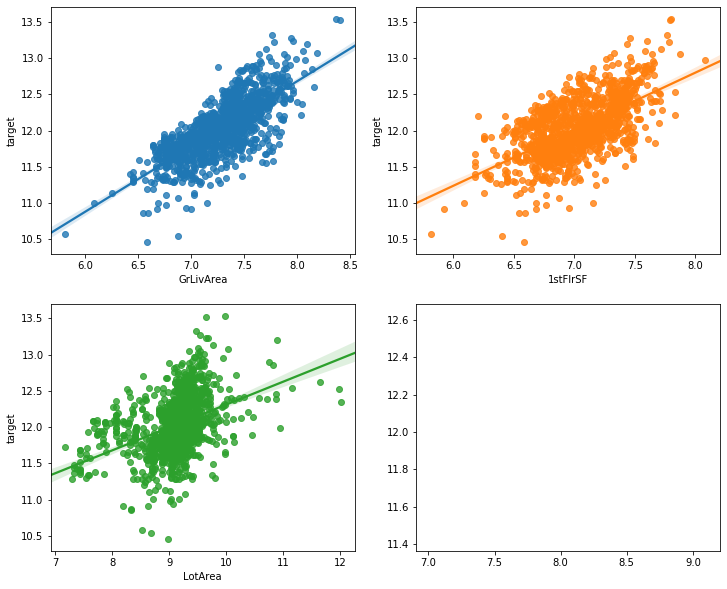

In [37]:
for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
    train_cleaned[col] = np.log1p(train_cleaned[col])

exp.corr_target(train_cleaned, 'target', ['GrLivArea', '1stFlrSF', 'LotArea'])

Moreover, we have already transformed some categorical features into ordinal ones

             BsmtQual  KitchenQual  GarageQual  GarageCond  ExterQual  \
BsmtQual     1.000000     0.511100    0.171536    0.188111   0.554887   
KitchenQual  0.511100     1.000000    0.232329    0.224139   0.714989   
GarageQual   0.171536     0.232329    1.000000    0.955815   0.214681   
GarageCond   0.188111     0.224139    0.955815    1.000000   0.210297   
ExterQual    0.554887     0.714989    0.214681    0.210297   1.000000   
HeatingQC    0.403084     0.499017    0.176256    0.181200   0.520420   
target       0.607152     0.690173    0.372389    0.365264   0.688002   

             HeatingQC    target  
BsmtQual      0.403084  0.607152  
KitchenQual   0.499017  0.690173  
GarageQual    0.176256  0.372389  
GarageCond    0.181200  0.365264  
ExterQual     0.520420  0.688002  
HeatingQC     1.000000  0.483002  
target        0.483002  1.000000  


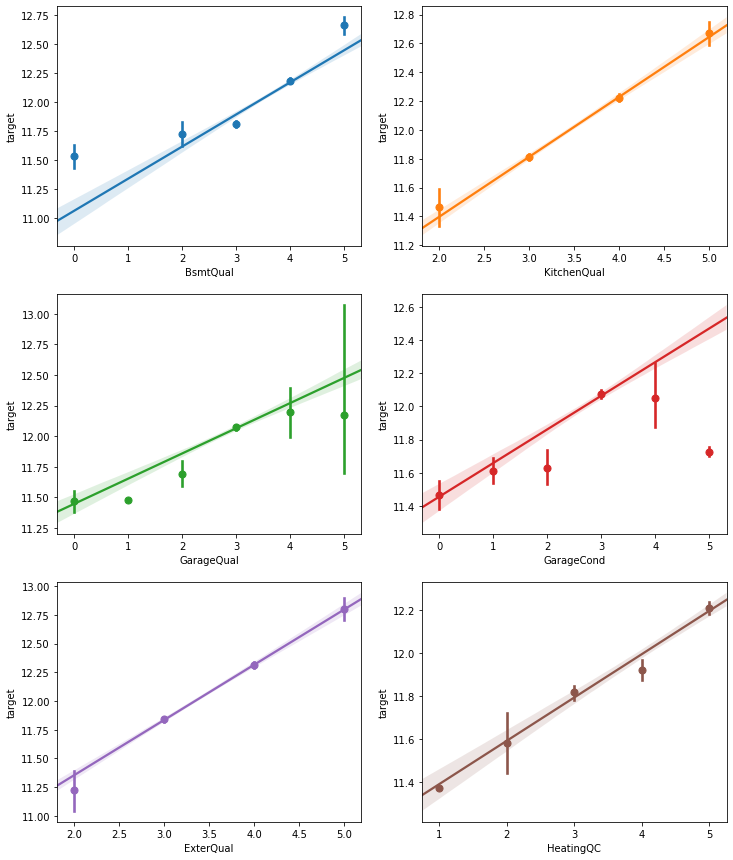

In [38]:
train_cleaned = make_ordinal(['BsmtQual', 'KitchenQual',
                              'GarageQual','GarageCond', 
                              'ExterQual', 'HeatingQC']).fit_transform(train_cleaned)

exp.corr_target(train_cleaned, 'target', ['BsmtQual', 'KitchenQual',
                                          'GarageQual','GarageCond',
                                          'ExterQual', 'HeatingQC'], x_estimator=np.mean)

We indeed observe a linear relation between the target and some of these features. For others it will be probably be better to use a different encoding.

At last, at least regarding what we have already implemented, we recoded a few categories following common sense. The goal here is to not train on too rare categories as this can lead to poor generalizability of the model. We report here only one of those transformations as an example

,count,mean,max,min,median,std
GarageType,,,,,,
Attchd,705,12.154445,13.534474,10.933000,12.119975,0.340577
BuiltIn,76,12.381833,13.275829,11.418626,12.334850,0.393289
Detchd,320,11.771839,13.071072,10.976799,11.763692,0.272710
NoGrg,65,11.468998,12.208575,10.460271,11.492733,0.351975


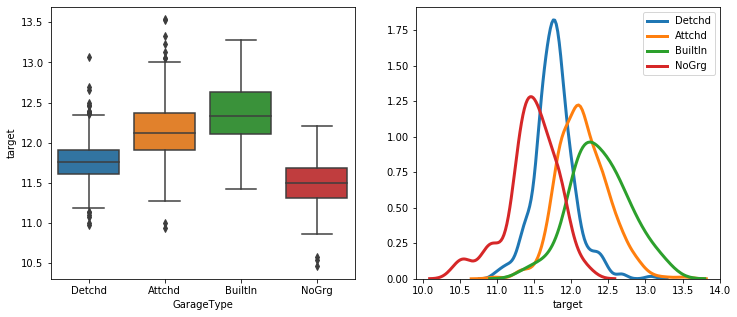

In [39]:
train_cleaned = recode_cat().fit_transform(train_cleaned)

exp.segm_target(train_cleaned, 'GarageType', 'target')

As we can see, the differences among different categories are more clear. This will definitely help the models.


## New features and what suggested them

We will now use some insights gained during the data exploration phase to make better features.

We noticed a good correlation between TotRmsAbvGrd, GrLivArea, and BedroomAbvGr, which is nothing shocking. Let's see what an interaction between the two looks like.

              GrLivArea  TotRmsAbvGrd  BedroomAbvGr  sf_per_room  \
GrLivArea      1.000000      0.819665      0.543195    -0.726105   
TotRmsAbvGrd   0.819665      1.000000      0.677524    -0.927202   
BedroomAbvGr   0.543195      0.677524      1.000000    -0.672979   
sf_per_room   -0.726105     -0.927202     -0.672979     1.000000   
bedroom_prop  -0.217718     -0.229407      0.530716     0.164960   
target         0.741597      0.543633      0.210188    -0.465772   

              bedroom_prop    target  
GrLivArea        -0.217718  0.741597  
TotRmsAbvGrd     -0.229407  0.543633  
BedroomAbvGr      0.530716  0.210188  
sf_per_room       0.164960 -0.465772  
bedroom_prop      1.000000 -0.320894  
target           -0.320894  1.000000  


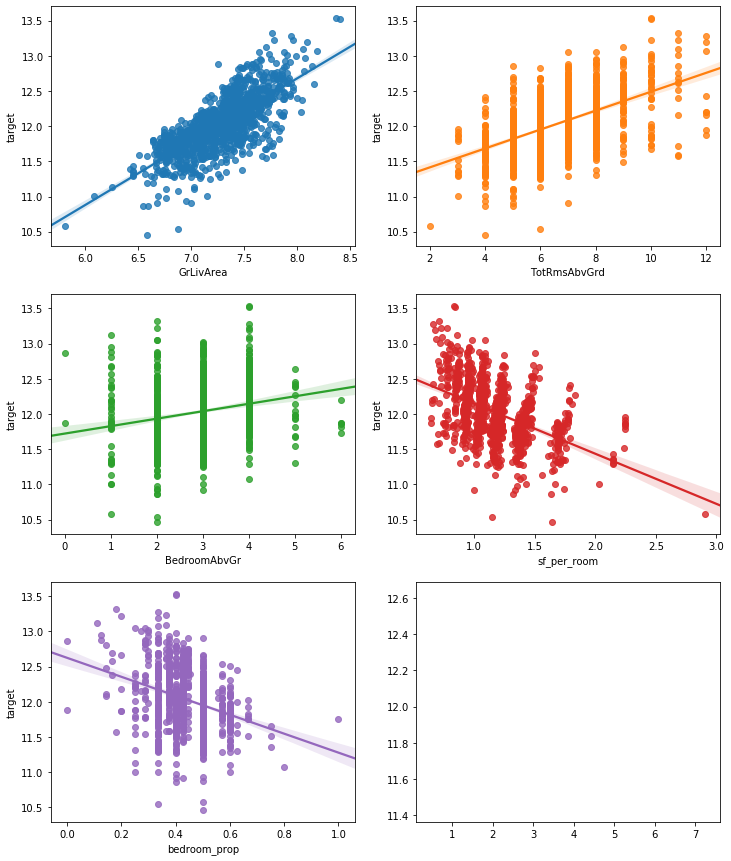

In [40]:
def SF_per_room(data):
    data['sf_per_room'] = data['GrLivArea'] / data['TotRmsAbvGrd']
    return data

def bedroom_prop(data):
    data['bedroom_prop'] = data['BedroomAbvGr'] / data['TotRmsAbvGrd']
    return data

train_cleaned = SF_per_room(train_cleaned)
train_cleaned = bedroom_prop(train_cleaned)

exp.corr_target(data=train_cleaned, 
                cols=['GrLivArea', 'TotRmsAbvGrd', 'BedroomAbvGr', 'sf_per_room', 'bedroom_prop'], 
                target='target')

It looks we found something: the bigger the house, the more it costs, but the bigger the rooms (on average), the less the house is expensive.

Next, we have a lot of bath features that individually are not saying too much. Let's try to make something out of them.

              BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  total_bath  \
BsmtFullBath      1.000000     -0.149458 -0.053973 -0.031788    0.582381   
BsmtHalfBath     -0.149458      1.000000 -0.019015 -0.011742    0.031650   
FullBath         -0.053973     -0.019015  1.000000  0.162049    0.703567   
HalfBath         -0.031788     -0.011742  0.162049  1.000000    0.408878   
total_bath        0.582381      0.031650  0.703567  0.408878    1.000000   
target            0.246349      0.006646  0.589437  0.343117    0.677673   

                target  
BsmtFullBath  0.246349  
BsmtHalfBath  0.006646  
FullBath      0.589437  
HalfBath      0.343117  
total_bath    0.677673  
target        1.000000  


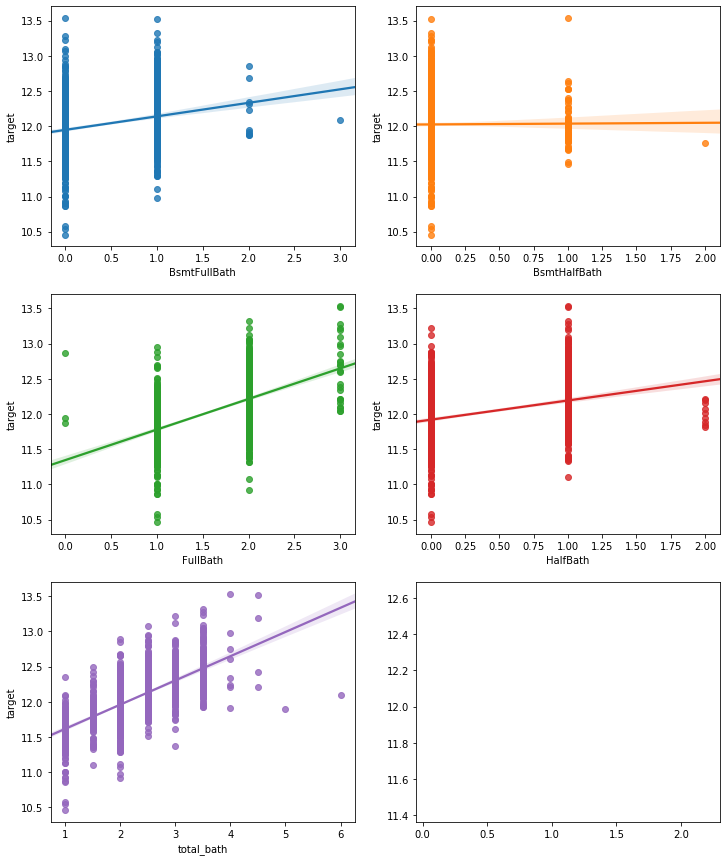

In [41]:
def total_bath(data):
    data['total_bath'] = data[[col for col in data.columns if 'FullBath' in col]].sum(axis=1) \
                        + 0.5 * data[[col for col in data.columns if 'HalfBath' in col]].sum(axis=1)
    return data

train_cleaned = total_bath(train_cleaned)
exp.corr_target(data=train_cleaned, 
                cols=[col for col in train_cleaned if 'Bath' in col] + ['total_bath'], 
                target='target')

This is indeed a clearer signal and we should consider using this feature and dropping the other bath features.

We also have quite some features regarding external area (porch, Lot, Pool), but with the exception of LotArea, they are not very relevant. We thus can try to see if some interaction with the internal area is relevant.

            LotArea  GrLivArea  lot_prop    target
LotArea    1.000000   0.375878  0.683041  0.407437
GrLivArea  0.375878   1.000000 -0.418644  0.741597
lot_prop   0.683041  -0.418644  1.000000 -0.185828
target     0.407437   0.741597 -0.185828  1.000000


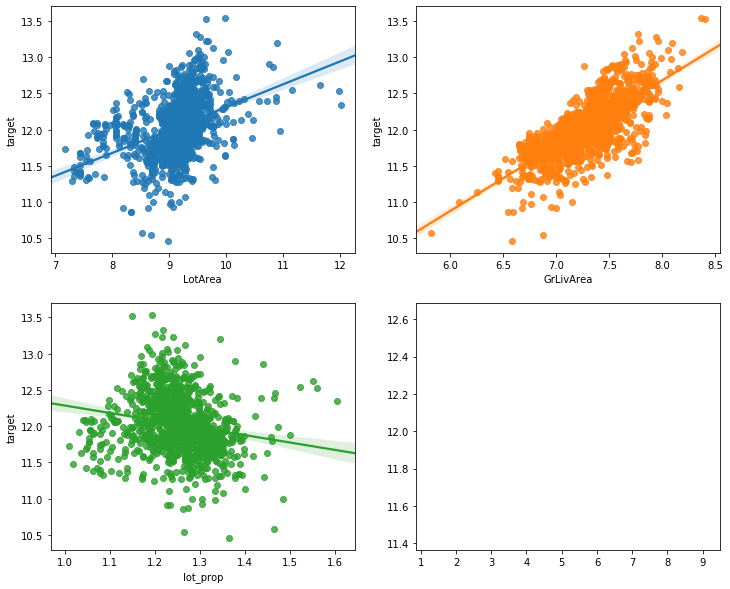

In [42]:
def lot_prop(data):
    data['lot_prop'] = data['LotArea'] / data['GrLivArea']
    return data

train_cleaned = lot_prop(train_cleaned)

exp.corr_target(data=train_cleaned,
                cols=['LotArea', 'GrLivArea', 'lot_prop'],
                target='target')

Nothing game-changing here but, with the same spirity, we can see what role what we can call service areas (Basement and Garage) are playing.

              TotalBsmtSF  GarageArea  service_area    target
TotalBsmtSF      1.000000    0.474743      0.941255  0.641253
GarageArea       0.474743    1.000000      0.744070  0.673793
service_area     0.941255    0.744070      1.000000  0.745304
target           0.641253    0.673793      0.745304  1.000000


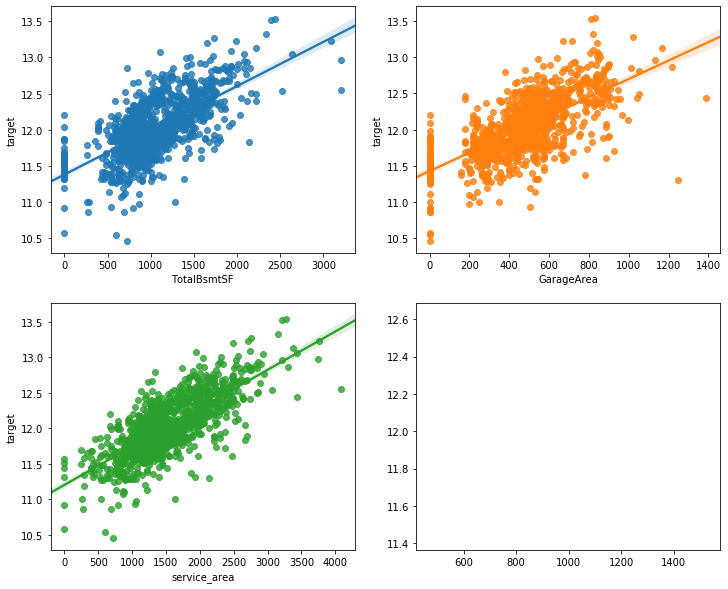

In [43]:
def service_area(data):
    data['service_area'] = data['TotalBsmtSF'] + data['GarageArea']
    return data

train_cleaned = service_area(train_cleaned)

exp.corr_target(data=train_cleaned,
                cols=['TotalBsmtSF', 'GarageArea', 'service_area'],
                target='target')

Since we already have GarageCars to describe the Garage and this new feature is very correlated with the basement SF, we could consider if it is better to use it and drop the original two.

At last, for now, we can use a very powerful but dangerous encoding technique to make a better use of `Neighborhood`. We want to use *target encoding* and, as we will see, it will give us a very predictive feature. However, one must be cautious about using this kind of encoding as it easily lead to severe overfitting.

Two things can prevent the overfitting: the use of pipeline (so we are sure that the encoding happens only on the training set) and some smoothing techniques (so that there is some noise in the feature and the signal is not unrealistically clean). We will implement these features shortly but, for now, we explore the possibilities we have.

                     GrLivArea  Neig_target_mean  Neig_target_std  \
GrLivArea             1.000000          0.472654         0.069002   
Neig_target_mean      0.472654          1.000000        -0.005510   
Neig_target_std       0.069002         -0.005510         1.000000   
Neig_GrLivArea_mean   0.539327          0.876378         0.127942   
Neig_GrLivArea_std   -0.200661         -0.485380         0.467475   
target                0.741597          0.754919        -0.004160   

                     Neig_GrLivArea_mean  Neig_GrLivArea_std    target  
GrLivArea                       0.539327           -0.200661  0.741597  
Neig_target_mean                0.876378           -0.485380  0.754919  
Neig_target_std                 0.127942            0.467475 -0.004160  
Neig_GrLivArea_mean             1.000000           -0.372058  0.661594  
Neig_GrLivArea_std             -0.372058            1.000000 -0.366422  
target                          0.661594           -0.366422  1.000000  


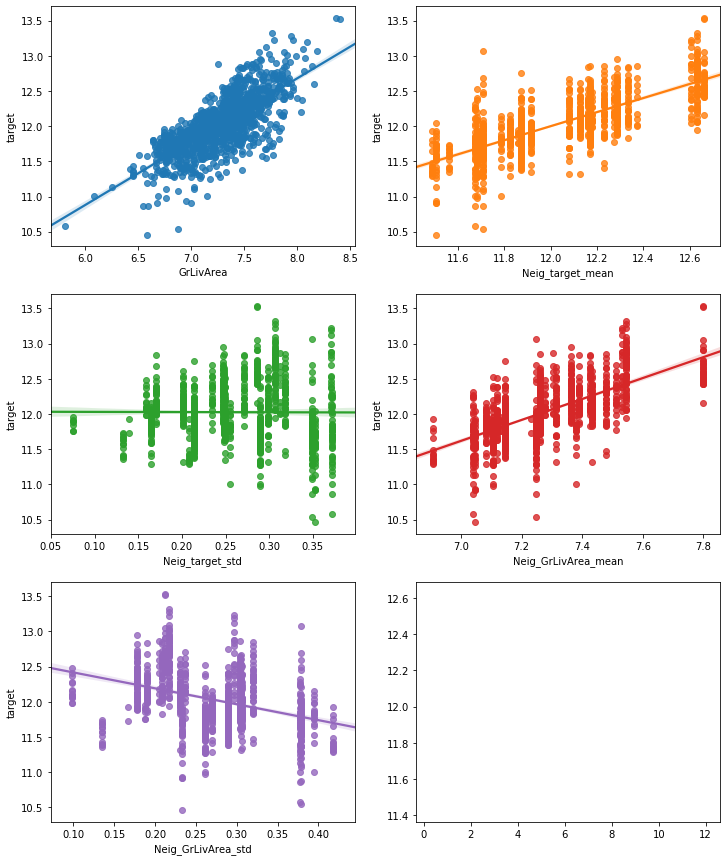

In [44]:
def tr_neighborhood(data, y=None):
    # mean and standard deviation of the price per Neighborhood
    means = data.groupby('Neighborhood')['target'].mean()
    stds = data.groupby('Neighborhood')['target'].std()
    data['Neig_target_mean'] = data['Neighborhood'].map(means)
    data['Neig_target_std'] = data['Neighborhood'].map(stds)
    # mean and standard deviation of the house size per Neighborhood
    means = data.groupby('Neighborhood')['GrLivArea'].mean()
    stds = data.groupby('Neighborhood')['GrLivArea'].std()
    data['Neig_GrLivArea_mean'] = data['Neighborhood'].map(means)
    data['Neig_GrLivArea_std'] = data['Neighborhood'].map(stds)
    
    return data

train_cleaned = tr_neighborhood(train_cleaned)

exp.corr_target(train_cleaned, 'target', ['GrLivArea',
                                          'Neig_target_mean','Neig_target_std',
                                          'Neig_GrLivArea_mean', 'Neig_GrLivArea_std' 
                                          ])

It looks like the target encoding with the mean is very powerful and not very correlated with the other features. We will use this one.

The same could be done with MSSubclass, being a very mysterious feature.

                     GrLivArea  MSSC_target_mean  MSSC_target_std  \
GrLivArea             1.000000          0.475976        -0.001896   
MSSC_target_mean      0.475976          1.000000         0.143940   
MSSC_target_std      -0.001896          0.143940         1.000000   
MSSC_GrLivArea_mean   0.659202          0.722050        -0.002876   
MSSC_GrLivArea_std   -0.170948         -0.173036         0.581542   
target                0.741597          0.585262         0.084243   

                     MSSC_GrLivArea_mean  MSSC_GrLivArea_std    target  
GrLivArea                       0.659202           -0.170948  0.741597  
MSSC_target_mean                0.722050           -0.173036  0.585262  
MSSC_target_std                -0.002876            0.581542  0.084243  
MSSC_GrLivArea_mean             1.000000           -0.259326  0.422588  
MSSC_GrLivArea_std             -0.259326            1.000000 -0.101272  
target                          0.422588           -0.101272  1.000000  


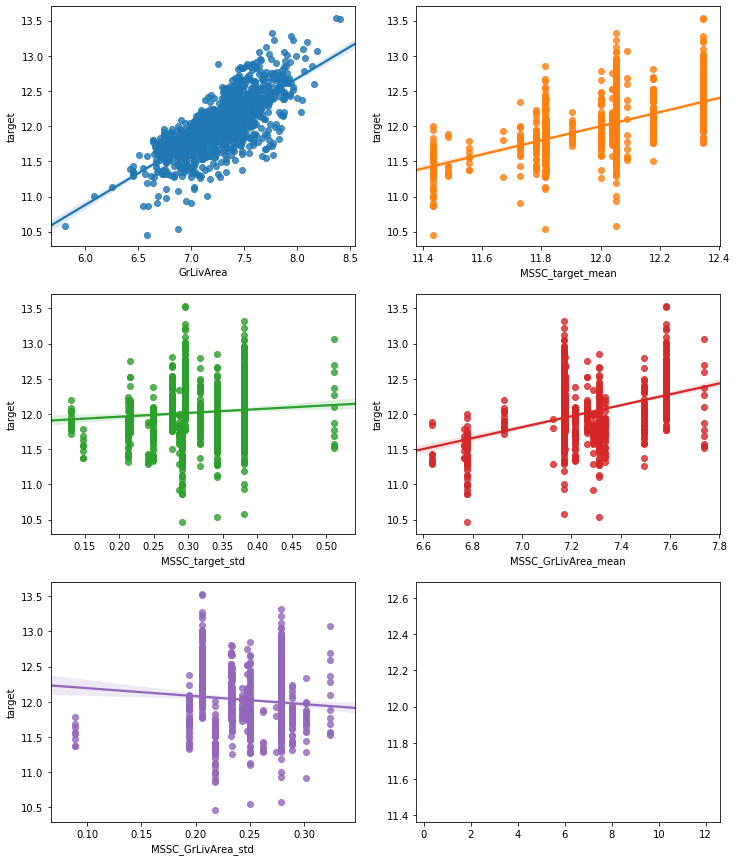

In [45]:
def tr_mssubclass(data, y=None):
    # mean and standard deviation of the price per Neighborhood
    means = data.groupby('MSSubClass')['target'].mean()
    stds = data.groupby('MSSubClass')['target'].std()
    data['MSSC_target_mean'] = data['MSSubClass'].map(means)
    data['MSSC_target_std'] = data['MSSubClass'].map(stds)
    # mean and standard deviation of the house size per Neighborhood
    means = data.groupby('MSSubClass')['GrLivArea'].mean()
    stds = data.groupby('MSSubClass')['GrLivArea'].std()
    data['MSSC_GrLivArea_mean'] = data['MSSubClass'].map(means)
    data['MSSC_GrLivArea_std'] = data['MSSubClass'].map(stds)
    
    return data

train_cleaned = tr_mssubclass(train_cleaned)

exp.corr_target(train_cleaned, 'target', ['GrLivArea',
                                          'MSSC_target_mean','MSSC_target_std',
                                          'MSSC_GrLivArea_mean', 'MSSC_GrLivArea_std' 
                                          ])

Not as evident as before but the mean target encoding looks promising. Being a very sparse feature, we will need to be careful with this encoding as there are a few very rare features and this, as mentioned before, will lead to overfitting (especially with some algorithms).


## Feature selection

We have seen from the previous models already that some features do not look important at all. Not only they slow down the learning, but they can even make our models learn the wrong relationships. We thus now modify the pipeline in order to get rid of these features (it also makes the processing a bit quicker, computation-wise)

In [46]:
class general_cleaner(BaseEstimator, TransformerMixin):
    '''
    This class applies what we know from the documetation.
    It cleans some known missing values
    If flags the missing values

    This process is supposed to happen as first step of any pipeline
    '''
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #LotFrontage
        X.loc[X.LotFrontage.isnull(), 'LotFrontage'] = 0
        #Alley
        X.loc[X.Alley.isnull(), 'Alley'] = "NoAlley"
        #MSSubClass
        X['MSSubClass'] = X['MSSubClass'].astype(str)
        #MissingBasement
        fil = ((X.BsmtQual.isnull()) & (X.BsmtCond.isnull()) & (X.BsmtExposure.isnull()) &
              (X.BsmtFinType1.isnull()) & (X.BsmtFinType2.isnull()))
        fil1 = ((X.BsmtQual.notnull()) | (X.BsmtCond.notnull()) | (X.BsmtExposure.notnull()) |
              (X.BsmtFinType1.notnull()) | (X.BsmtFinType2.notnull()))
        X.loc[fil1, 'MisBsm'] = 0
        X.loc[fil, 'MisBsm'] = 1 # made explicit for safety
        #BsmtQual
        X.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
        #BsmtCond
        X.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
        #BsmtExposure
        X.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
        #BsmtFinType1
        X.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
        #BsmtFinType2
        X.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
        #BsmtFinSF1
        X.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
        #BsmtFinSF2
        X.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
        #BsmtUnfSF
        X.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
        #TotalBsmtSF
        X.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
        #BsmtFullBath
        X.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
        #BsmtHalfBath
        X.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
        #FireplaceQu
        X.loc[(X.Fireplaces == 0) & (X.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
        #MisGarage
        fil = ((X.GarageYrBlt.isnull()) & (X.GarageType.isnull()) & (X.GarageFinish.isnull()) &
              (X.GarageQual.isnull()) & (X.GarageCond.isnull()))
        fil1 = ((X.GarageYrBlt.notnull()) | (X.GarageType.notnull()) | (X.GarageFinish.notnull()) |
              (X.GarageQual.notnull()) | (X.GarageCond.notnull()))
        X.loc[fil1, 'MisGarage'] = 0
        X.loc[fil, 'MisGarage'] = 1
        #GarageYrBlt
        X.loc[X.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
        X.loc[fil, 'GarageYrBlt'] = X['YearBuilt']  # if no garage, use the age of the building
        #GarageType
        X.loc[fil, 'GarageType'] = "NoGrg" #missing garage
        #GarageFinish
        X.loc[fil, 'GarageFinish'] = "NoGrg" #missing
        #GarageQual
        X.loc[fil, 'GarageQual'] = "NoGrg" #missing
        #GarageCond
        X.loc[fil, 'GarageCond'] = "NoGrg" #missing
        #Fence
        X.loc[X.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
        #Pool
        fil = ((X.PoolArea == 0) & (X.PoolQC.isnull()))
        X.loc[fil, 'PoolQC'] = 'NoPool' 
        
        # not useful features
        del X['Id']
        del X['MiscFeature']  # we already know it doesn't matter
        del X['Condition1']
        del X['Condition2']
        del X['Exterior1st']
        del X['Exterior2nd']
        del X['Functional']
        del X['Heating']
        del X['PoolQC']
        del X['RoofMatl']
        del X['RoofStyle']
        del X['SaleCondition']
        del X['SaleType']
        del X['Utilities']
        del X['BsmtFinType1']
        del X['BsmtFinType2']
        del X['BsmtFinSF1']
        del X['BsmtFinSF2']
        del X['Electrical']
        del X['Foundation']
        del X['Street']
        del X['Fence']
        del X['LandSlope']
        del X['LowQualFinSF']
        del X['FireplaceQu']
        del X['PoolArea']
        del X['MiscVal']
        del X['MoSold']
        del X['YrSold']
        
        # after model iterations
        del X['KitchenAbvGr']
        del X['GarageQual']
        del X['GarageCond'] 
        
        return X

The choice was driven by a combination of factors, for example:

* the feature has mainly one value
* the feature does not display any particular pattern (and we want to keep the model simple)
* The feature should not play a role in determining the cost (this comes with the knowledge and biases of the author)

Then there is a number of feature we want to create and we are not particularly sure if they will be helpful or not. For example, we have seen that some features can be safely converted into ordinal ones but others do not display an equally clear pattern and might be more useful as dummies. As another example, we created a new feature for the total number of baths and it looks promising but we are not sure if it is worth dropping all the other original features in its favor. 

We can stay here all day trying to think about the right combination of transformations we need for the optimal set of features but we are getting better in the use of pipelines, it is time to exploit that.

We can design our transformers in order to have parameters that determine whether or not a feature should be transformed/created. In this way, we can tune those parameters with GridSearch or RandomSearch and obtain the best set for every model.

*Note: the code is hidden but rich of insights (or so I like to believe), feel free to expand the next cell*

In [47]:
class tr_numeric(BaseEstimator, TransformerMixin):
    def __init__(self, SF_room=True, bedroom=True, bath=True, lot=True, service=True):
        self.columns = []  # useful to well behave with FeatureUnion
        self.SF_room = SF_room
        self.bedroom = bedroom
        self.bath = bath
        self.lot = lot
        self.service = service
     

    def fit(self, X, y=None):
        return self
    

    def remove_skew(self, X, column):
        X[column] = np.log1p(X[column])
        return X


    def SF_per_room(self, X):
        if self.SF_room:
            X['sf_per_room'] = X['GrLivArea'] / X['TotRmsAbvGrd']
        return X


    def bedroom_prop(self, X):
        if self.bedroom:
            X['bedroom_prop'] = X['BedroomAbvGr'] / X['TotRmsAbvGrd']
            del X['BedroomAbvGr'] # the new feature makes it redundant and it is not important
        return X


    def total_bath(self, X):
        if self.bath:
            X['total_bath'] = (X[[col for col in X.columns if 'FullBath' in col]].sum(axis=1) +
                             0.5 * X[[col for col in X.columns if 'HalfBath' in col]].sum(axis=1))
            del X['FullBath']  # redundant 

        del X['HalfBath']  # not useful anyway
        del X['BsmtHalfBath']
        del X['BsmtFullBath']
        return X


    def lot_prop(self, X):
        if self.lot:
            X['lot_prop'] = X['LotArea'] / X['GrLivArea']
        return X 


    def service_area(self, X):
        if self.service:
            X['service_area'] = X['TotalBsmtSF'] + X['GarageArea']
            del X['TotalBsmtSF']
            del X['GarageArea']
        return X
    

    def transform(self, X, y=None):
        for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
            X = self.remove_skew(X, col)

        X = self.SF_per_room(X)
        X = self.bedroom_prop(X)
        X = self.total_bath(X)
        X = self.lot_prop(X)
        X = self.service_area(X)

        self.columns = X.columns
        return X
    

    def get_features_name(self):
        return self.columns
    
    
class drop_columns(BaseEstimator, TransformerMixin):
    '''
    Drops columns that are not useful for the model
    '''
    def __init__(self, lasso=False, ridge=False, forest=False, xgb=False, lgb=False):
        self.columns = []
        self.lasso = lasso
        self.ridge = ridge
        self.forest = forest
        self.xgb = xgb
        self.lgb = lgb
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        to_drop = [col for col in X.columns if 'NoGrg' in col]  # dropping dummies that are redundant
        to_drop += [col for col in X.columns if 'NoBsmt' in col]

        if self.lasso:
            to_drop += [col for col in X.columns if 'BsmtExposure' in col]
            to_drop += [col for col in X.columns if 'BsmtCond' in col]
            to_drop += [col for col in X.columns if 'ExterCond' in col]
            to_drop += [col for col in X.columns if 'HouseStyle' in col] 
            to_drop += [col for col in X.columns if 'LotShape' in col] 
            to_drop += [col for col in X.columns if 'LotFrontage' in col]
            to_drop += [col for col in X.columns if 'GarageYrBlt' in col] 
            to_drop += [col for col in X.columns if 'GarageType' in col] 
            to_drop += ['OpenPorchSF', '3SsnPorch'] 
        if self.ridge: 
            to_drop += [col for col in X.columns if 'BsmtExposure' in col]
            to_drop += [col for col in X.columns if 'BsmtCond' in col]
            to_drop += [col for col in X.columns if 'ExterCond' in col] 
            to_drop += [col for col in X.columns if 'LotFrontage' in col]
            to_drop += [col for col in X.columns if 'LotShape' in col] 
            to_drop += [col for col in X.columns if 'HouseStyle' in col] 
            to_drop += [col for col in X.columns if 'GarageYrBlt' in col]
            to_drop += [col for col in X.columns if 'GarageCars' in col] 
            to_drop += [col for col in X.columns if 'BldgType' in col] 
            to_drop += ['OpenPorchSF', '3SsnPorch']
        if self.forest: 
            to_drop += [col for col in X.columns if 'BsmtExposure' in col]
            to_drop += [col for col in X.columns if 'BsmtCond' in col]
            to_drop += [col for col in X.columns if 'ExterCond' in col] 
            to_drop += ['OpenPorchSF', '3SsnPorch'] 
        if self.xgb:
            to_drop += [col for col in X.columns if 'BsmtExposure' in col]
            to_drop += [col for col in X.columns if 'BsmtCond' in col]
            to_drop += [col for col in X.columns if 'ExterCond' in col]
        if self.lgb: 
            to_drop += [col for col in X.columns if 'LotFrontage' in col] 
            to_drop += [col for col in X.columns if 'HouseStyle' in col]
            to_drop += ['MisBsm'] 
            
        
        for col in to_drop:
            try:
                del X[col]
            except KeyError:
                pass
            
        self.columns = X.columns
        return X
    
    def get_feature_names(self):
        return list(self.columns)
    
    
class make_ordinal(BaseEstimator, TransformerMixin):
    '''
    Transforms ordinal features in order to have them as numeric (preserving the order)
    If unsure about converting or not a feature (maybe making dummies is better), make use of
    extra_cols and unsure_conversion
    '''
    def __init__(self, cols, extra_cols=None, include_extra='include'):
        self.cols = cols
        self.extra_cols = extra_cols
        self.mapping = {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        self.include_extra = include_extra  # either include, dummies, or drop (any other option)
    

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if self.extra_cols:
            if self.include_extra == 'include':
                self.cols += self.extra_cols
            elif self.include_extra == 'dummies':
                pass
            else:
                for col in self.extra_cols:
                    del X[col]
        
        for col in self.cols:
            X.loc[:, col] = X[col].map(self.mapping).fillna(0)
        return X
    
    
class recode_cat(BaseEstimator, TransformerMixin):        
    '''
    Recodes some categorical variables according to the insights gained from the
    data exploration phase.
    '''
    def __init__(self, mean_weight=10, te_neig=True, te_mssc=True):
        self.mean_tot = 0
        self.mean_weight = mean_weight
        self.smooth_neig = {}
        self.smooth_mssc = {}
        self.te_neig = te_neig
        self.te_mssc = te_mssc
    
    
    def smooth_te(self, data, target, col):
        tmp_data = data.copy()
        tmp_data['target'] = target
        mean_tot = tmp_data['target'].mean()
        means = tmp_data.groupby(col)['target'].mean()
        counts = tmp_data.groupby(col)['target'].count()

        smooth = ((counts * means + self.mean_weight * mean_tot) / 
                       (counts + self.mean_weight))
        return mean_tot, smooth
    
    def fit(self, X, y):
        if self.te_neig:
            self.mean_tot, self.smooth_neig = self.smooth_te(data=X, target=y, col='Neighborhood')

        if self.te_mssc:
            self.mean_tot, self.smooth_mssc = self.smooth_te(X, y, 'MSSubClass')
            
        return self
    
    
    def tr_GrgType(self, data):
        data['GarageType'] = data['GarageType'].map({'Basment': 'Attchd',
                                                     'CarPort': 'Detchd',
                                                     '2Types': 'Attchd' }).fillna(data['GarageType'])
        return data
    
    
    def tr_LotShape(self, data):
        fil = (data.LotShape != 'Reg')
        data['LotShape'] = 1
        data.loc[fil, 'LotShape'] = 0
        return data
    
    
    def tr_LandCont(self, data):
        fil = (data.LandContour == 'HLS') | (data.LandContour == 'Low')
        data['LandContour'] = 0
        data.loc[fil, 'LandContour'] = 1
        return data
    
    
    def tr_LandSlope(self, data):
        fil = (data.LandSlope != 'Gtl')
        data['LandSlope'] = 0
        data.loc[fil, 'LandSlope'] = 1
        return data
    
    
    def tr_MSZoning(self, data):
        data['MSZoning'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                 'C (all)': 'RM', # commercial and medium density
                                                 'FV': 'RM'}).fillna(data['MSZoning'])
        return data
    
    
    def tr_Alley(self, data):
        fil = (data.Alley != 'NoAlley')
        data['Alley'] = 0
        data.loc[fil, 'Alley'] = 1
        return data
    
    
    def tr_LotConfig(self, data):
        data['LotConfig'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                   'FR2': 'Corner'}).fillna(data['LotConfig'])
        return data
    
    
    def tr_BldgType(self, data):
        data['BldgType'] = data['BldgType'].map({'Twnhs' : 'TwnhsE',
                                                 '2fmCon': 'Duplex'}).fillna(data['BldgType'])
        return data
    
    
    def tr_MasVnrType(self, data):
        data['MasVnrType'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
        return data


    def tr_HouseStyle(self, data):
        data['HouseStyle'] = data['HouseStyle'].map({'1.5Fin': '1.5Unf',
                                                     '2.5Fin': '2Story',
                                                     '2.5Unf': '2Story',
                                                     'SLvl': 'SFoyer'}).fillna(data['HouseStyle'])
        return data


    def tr_Neighborhood(self, data):
        if self.te_neig:
            data['Neighborhood'] = data['Neighborhood'].map(self.smooth_neig).fillna(self.mean_tot)
        return data
    
    def tr_MSSubClass(self, data):
        if self.te_mssc:
            data['MSSubClass'] = data['MSSubClass'].map(self.smooth_mssc).fillna(self.mean_tot)
        return data
    
    
    def transform(self, X, y=None):
        X = self.tr_GrgType(X)
        X = self.tr_LotShape(X)
        X = self.tr_LotConfig(X)
        X = self.tr_MSZoning(X)
        X = self.tr_Alley(X)
        X = self.tr_LandCont(X)
        X = self.tr_BldgType(X)
        X = self.tr_MasVnrType(X)
        X = self.tr_HouseStyle(X)
        X = self.tr_Neighborhood(X)
        X = self.tr_MSSubClass(X)
        return X

In [48]:
numeric_pipe = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric())])


cat_pipe = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify())])


processing_pipe = dfp.FeatureUnion_df(transformer_list=[('cat', cat_pipe),
                                                 ('num', numeric_pipe)])


full_pipe = Pipeline([('gen_cl', general_cleaner()), 
                      ('proc', processing_pipe), 
                      ('scaler', dfp.df_scaler()), 
                      ('dropper', drop_columns())])

tmp = train_set.copy()

tmp = full_pipe.fit_transform(tmp, y)  # we need to provide y too for the target encoding

tmp.head()

,MSSubClass,Alley,LotShape,LandContour,Neighborhood,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,KitchenQual,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,BldgType_1Fam,BldgType_Duplex,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,CentralAir_N,CentralAir_Y,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MisBsm,MisGarage,sf_per_room,bedroom_prop,total_bath,lot_prop,service_area
1231,-1.045296,-0.260318,0.739202,-0.24691,-0.586959,-0.691394,0.0,-3.956431,0.0,0.0,-1.195302,-0.766243,0.523753,-0.523753,1.954017,-0.265908,-1.629470,-2.245318,4.018340,-0.346521,-0.358819,1.015558,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,-0.271413,0.271413,-1.236642,-0.264054,1.625961,-0.55952,-0.636254,1.180784,-0.256541,-0.15102,0.30292,0.378144,0.178389,-1.532470,-0.520843,-0.298452,-1.099477,-0.571568,-1.297802,0.323866,-0.807309,-0.495641,-0.336957,-0.959872,-0.543172,0.317934,-0.737686,-0.699962,-0.361219,-0.114858,-0.273783,5.952940,-0.242976,0.052722,-1.165050,-0.248251,0.552158,-1.918266
1456,0.070792,-0.260318,0.739202,-0.24691,-0.586959,-0.691394,0.0,-0.547664,0.0,0.0,-0.153656,0.737864,0.523753,-0.523753,-0.511766,-0.265908,0.613696,0.445371,-0.248859,-0.346521,-0.358819,1.015558,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,-0.271413,0.271413,0.808641,-0.264054,-0.615021,-0.55952,-0.636254,1.180784,-0.256541,-0.15102,0.30292,0.319926,0.153680,-0.805513,0.393770,-0.692632,0.546086,-0.571568,-1.297802,-0.080602,-0.807309,-0.880038,-0.953743,-0.959872,-0.997286,-1.015558,2.128905,-0.699962,1.448993,-0.114858,-0.273783,-0.167984,-0.242976,0.861310,-0.465947,-0.248251,0.848416,-0.372229
242,-1.027304,-0.260318,0.739202,-0.24691,-1.154642,-0.691394,0.0,-0.547664,0.0,0.0,-0.153656,-0.766243,-1.909298,1.909298,1.954017,-0.265908,-1.629470,0.445371,-0.248859,-0.346521,2.786919,-0.984680,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,3.684427,-3.684427,0.808641,-0.264054,-0.615021,-0.55952,-0.636254,1.180784,-0.256541,-0.15102,0.30292,0.174380,-1.130681,-0.805513,-1.435457,-2.335049,-1.680264,-0.571568,-0.077121,-0.694344,0.447417,-0.003745,-0.336957,-0.959872,-1.375715,-1.015558,-0.737686,-0.699962,0.883302,-0.114858,-0.273783,-0.167984,-0.242976,0.156130,0.582707,-1.517816,-1.115611,-1.141636
93,-1.048107,-0.260318,0.739202,-0.24691,-1.154642,-0.691394,0.0,-0.547664,0.0,0.0,0.887990,-0.766243,-1.909298,1.909298,1.954017,-0.265908,-1.629470,-2.245318,4.018340,-0.346521,-0.358819,-0.984680,1.443834,-0.27323,-0.67235,0.808641,-0.30292,3.684427,-3.684427,-1.236642,-0.264054,1.625961,-0.55952,-0.636254,1.180784,-0.256541,-0.15102,0.30292,0.087053,-0.425841,-0.078556,0.393770,-2.006565,0.642884,-0.571568,-0.918035,0.416179,1.540464,1.401969,1.513399,0.598918,-2.889430,0.317934,-0.737686,-0.699962,-0.361219,-0.114858,1.450568,-0.167984,-0.242976,-1.190595,0.000121,0.386531,-1.431775,0.353830
1268,-1.027304,-0.260318,0.739202,-0.24691,-0.586959,-0.691394,0.0,-0.547664,0.0,0.0,-1.195302,-0.766243,0.523753,-0.523753,-0.511766,-0.265908,0.613696,0.445371,-0.248859,-0.346521,2.786919,-0.984680,-0.692600,-0.27323,1.48732,-1.236642,-0.30292,-0.271413,0.271413,0.808641,-0.264054,-0.615021,-0.55952,-0.636254,1.180784,-0.256541,-0.15102,0.30292,0.611017,0.452947,-0.805513,-0.520843,-0.429845,-1.293073,0.455765,-0.361947,-0.748518,0.672858,0.167869,0.279828,-0.959872,-0.694543,-1.015558,-0.737686,-0.699962,-0.361219,-0.114858,-0.273783,-0.167984,-0.242976,-0.474547,-0.166332,-0.883034,0.288694,-0.605218


We are now ready to use these parameters in our search or the optimal model.

# Hyperparameter tuning

The key, and for some the novelty, of this phase is to tune both the parameters of the chosen algorithm (like the regularization in `Lasso`) and the one controlling on the creation of new features or on how to scale the data at the same time.

It is important, as before, to not fall too deep into the rabbit hole we need to be pragmatic. Most of the parameters we want to tune will have such a small influence on the model and such a high cost in terms of computation time that we have to be able to explore the sections of the parameter space that really matter.

To achieve that, it is a good practice to quickly iterate on different configurations and keep track of the effects of our choices. Even if this means coming back to the previous section and create something new. Depending on when you read this notebook, you will see different iterations of this phase (or probably the final iteration). I will try to explain as good as I can why some things were done and some other weren't.

As of now, the full pipeline (without the model) looks like this.

In [49]:
def grid_search(data, target, estimator, param_grid, scoring, cv, random=False):
    
    if random:
        grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, cv=cv, scoring=scoring, 
                                  n_iter=random, n_jobs=-1, random_state=434, iid=False)
    else:
        grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                            cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    
    pd.options.mode.chained_assignment = None  # turn on and off a warning of pandas
    tmp = data.copy()
    grid = grid.fit(tmp, target)
    pd.options.mode.chained_assignment = 'warn'
    
    result = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', 
                                                        ascending=False).reset_index()
    
    del result['params']
    times = [col for col in result.columns if col.endswith('_time')]
    params = [col for col in result.columns if col.startswith('param_')]
    
    result = result[params + ['mean_test_score', 'std_test_score'] + times]
    
    return result, grid.best_params_, grid.best_estimator_

In [50]:
full_pipe.get_params()

{'memory': None,
 'steps': [('gen_cl', general_cleaner()), ('proc', FeatureUnion_df(n_jobs=None,
                   transformer_list=[('cat',
                                      Pipeline(memory=None,
                                               steps=[('fs',
                                                       feat_sel(dtype='category')),
                                                      ('imp',
                                                       df_imputer(strategy='most_frequent')),
                                                      ('ord',
                                                       make_ordinal(cols=['BsmtQual',
                                                                          'KitchenQual',
                                                                          'ExterQual',
                                                                          'HeatingQC',
                                                                          'BsmtExposur

Pretty cumbersome but at the bottom of it we have all the hyperparameters we want to tune. Let's tune model by model.

## Tuning Lasso

As a reminder, in the model selection phase we have as a baseline for Lasso given by

In [51]:
results.loc[results.model_name=='lasso', ]

,model_name,rmse_train,rmse_test,mae_train,mae_test
0,lasso,0.018417,0.019999,18201.04773,17177.225144


Let's then create a pipeline for this model

In [52]:
lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_pipe),
                       ('scaler', dfp.df_scaler()),
                       ('dropper', drop_columns()), 
                       ('lasso', Lasso(alpha=0.01))])

The parameter space I want to explore, searching for the best configuration, is

In [53]:
lasso_params = {'lasso__alpha': [0.05, 0.01, 0.005, 0.001], 
                'lasso__tol': [0.005, 0.001, 0.0005, 0.0001],
                'proc__cat__dummies__drop_first': [True, False], 
                'proc__cat__recode__te_mssc': [True, False], 
                'proc__cat__recode__te_neig': [True, False],
                'proc__cat__ord__include_extra': ['include', 'dummies'], 
                'proc__num__transf__SF_room': [True, False], 
                'proc__num__transf__bath': [True, False], 
                'proc__num__transf__bedroom': [True, False], 
                'proc__num__transf__lot': [True, False], 
                'proc__num__transf__service': [True, False],
                'scaler__method': ['standard', 'robust'], 
                'dropper__drop': [True, False]}

These are 32768 different configurations to test on 5 folds. Even though Lasso is pretty quick and the data are not big, it can take quite a long time.

After a few iterations, and this is the last time I put all the steps of the process or this notebook becomes unbearable, we can restrict our search a bit. Namely,

* All the target encoding is giving higher score
* Dropping the variables at the end is never helpful
* The alpha parameter has to be searched on a different range
* The service area does not help
* total_bath always helps

These are still a lot of configurations. We will thus test only 200 random combinations

In [54]:
lasso_params = {'lasso__alpha': [0.002, 0.001, 0.0009, 0.0008], 
                'lasso__tol': [0.005, 0.001, 0.0005, 0.0001],
                'proc__cat__dummies__drop_first': [True, False],
                'proc__cat__ord__include_extra': ['include', 'dummies'], 
                'proc__num__transf__SF_room': [True, False],
                'proc__num__transf__bedroom': [True, False], 
                'proc__num__transf__lot': [True, False],
                'scaler__method': ['standard', 'robust']}

In [55]:
result_lasso, bp_lasso, best_lasso = grid_search(train_set, y, lasso_pipe, 
                                                 param_grid=lasso_params, cv=folds, scoring='neg_mean_squared_error', 
                                                 random=100)

# todo: apparently dropping the extra columns to transform to ordinal gives problems. It has to be fixed

In [56]:
result_lasso.head(10)

,param_scaler__method,param_proc__num__transf__lot,param_proc__num__transf__bedroom,param_proc__num__transf__SF_room,param_proc__cat__ord__include_extra,param_proc__cat__dummies__drop_first,param_lasso__tol,param_lasso__alpha,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,standard,False,False,False,include,True,0.005,0.001,-0.013884,0.001175,0.195656,0.030512,0.112371,0.000655
1,standard,True,False,True,dummies,True,0.001,0.001,-0.013885,0.001185,0.168620,0.001516,0.105954,0.001188
2,standard,True,False,False,include,True,0.001,0.001,-0.013885,0.001185,0.177545,0.001225,0.114592,0.001532
3,standard,False,False,False,dummies,True,0.0005,0.001,-0.013886,0.001186,0.190127,0.020814,0.117535,0.016371
4,standard,True,False,False,dummies,True,0.0005,0.001,-0.013886,0.001186,0.169124,0.001571,0.104020,0.001929
5,standard,False,False,True,dummies,True,0.001,0.001,-0.013887,0.001186,0.167973,0.000930,0.105732,0.002067
6,standard,True,False,False,include,True,0.0001,0.001,-0.013887,0.001186,0.179761,0.001704,0.114360,0.001877
7,standard,False,False,False,dummies,True,0.0001,0.001,-0.013887,0.001186,0.172335,0.003565,0.103716,0.001243
8,standard,True,False,True,include,True,0.0001,0.0009,-0.013894,0.001174,0.180137,0.001874,0.114755,0.001714
9,standard,False,True,True,include,True,0.005,0.001,-0.013898,0.001187,0.176997,0.001027,0.114834,0.001681


After this search, the best configuration is given by

In [57]:
bp_lasso

{'scaler__method': 'standard',
 'proc__num__transf__lot': False,
 'proc__num__transf__bedroom': False,
 'proc__num__transf__SF_room': False,
 'proc__cat__ord__include_extra': 'include',
 'proc__cat__dummies__drop_first': True,
 'lasso__tol': 0.005,
 'lasso__alpha': 0.001}

The model has now these coefficients

In [58]:
get_coef(best_lasso)

,feat,score
31,OverallQual,0.083025
53,service_area,0.080007
39,GrLivArea,0.049774
37,1stFlrSF,0.049554
38,2ndFlrSF,0.049419
4,Neighborhood,0.044640
32,OverallCond,0.043354
33,YearBuilt,0.032389
30,LotArea,0.028949
36,BsmtUnfSF,-0.024968


While the performance on our test set (which should not influence our hyperparameter tuning but it is nice to keep track of its evolution) is

Test set RMSE: 0.1263
Test set MAE: 14591.37


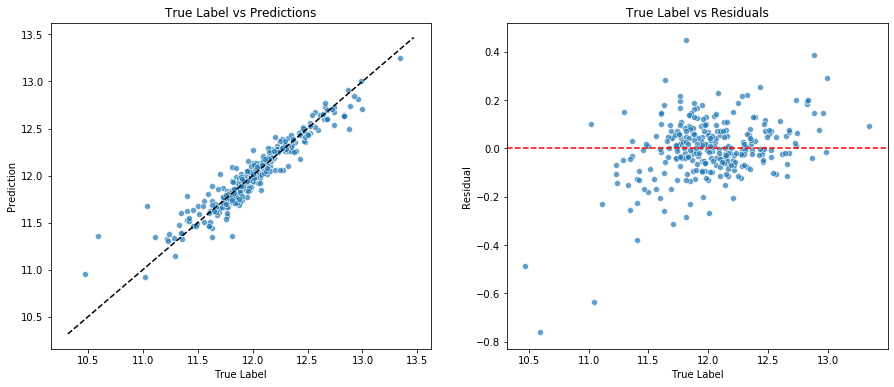

In [59]:
tmp = test_set.copy()
preds = best_lasso.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

In [60]:
numeric_lasso = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(lot=False, 
                                               bedroom=False, 
                                               SF_room=False))])


cat_lasso = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_lasso = dfp.FeatureUnion_df(transformer_list=[('cat', cat_lasso),
                                                 ('num', numeric_lasso)])

lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_lasso),
                       ('scaler', dfp.df_scaler(method='standard')),
                       ('dropper', drop_columns(lasso=True)), 
                       ('lasso', Lasso(alpha=0.001, tol=0.005))])

In [61]:
lasso_oof, coefs = cv_score(train_set, y, folds, lasso_pipe, imp_coef=True)

coefs

,mean,std
feat,,
OverallQual,0.083286,0.003093
service_area,0.078932,0.002313
2ndFlrSF,0.049664,0.006035
1stFlrSF,0.049538,0.006489
GrLivArea,0.048768,0.008201
Neighborhood,0.044442,0.003186
OverallCond,0.043416,0.002327
YearBuilt,0.031246,0.004268
LotArea,0.029090,0.002211


Train set RMSE: 0.1173
Train set MAE: 14797.63


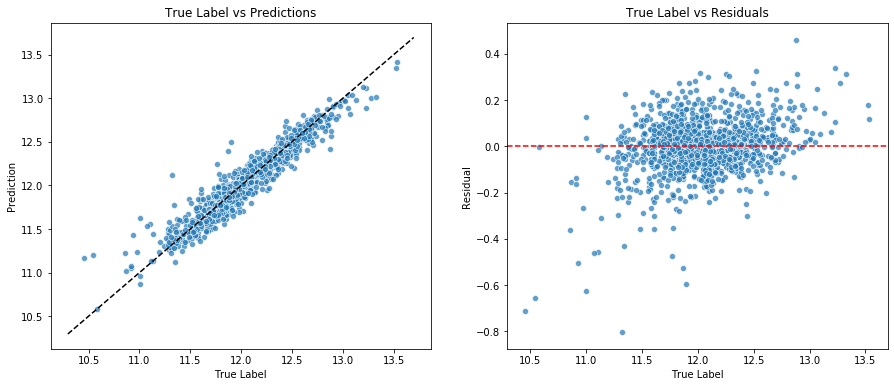

In [62]:
print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(y, lasso_oof)), 4)}')
print(f'Train set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(lasso_oof)), 2)}')
plot_predictions(train_set, y, lasso_oof)

Test set RMSE: 0.1264
Test set MAE: 14635.4


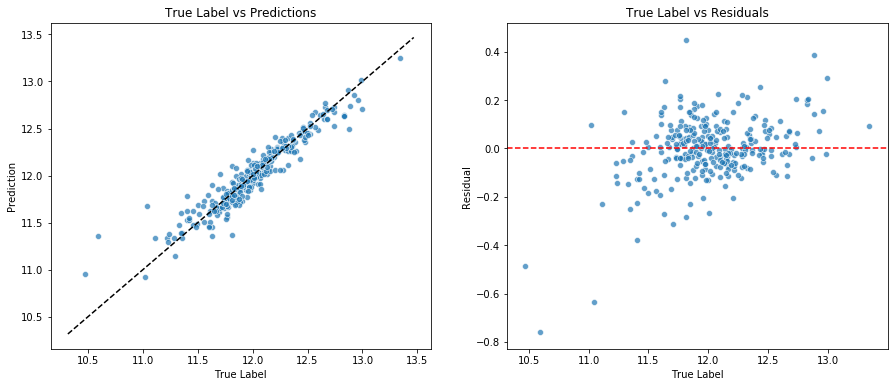

In [63]:
tmp = train_set.copy()
lasso_pipe.fit(tmp, y)
tmp = test_set.copy()
preds = lasso_pipe.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

Our effort of tuning Lasso a bit more, considering the creation of features and their selection as part of the tuning, led to an improvement of the model performance from the original 0.136 to the current 0.117. In terms of mean absolute error, we go from a little bit more than 18000 dollars to a bit less than 15000. In a real project, it is a good idea to keep track of the time and effort we put in fine tuning our model and evaluate if the project gets a significant benefit from this time and effort.

In this case, the tuning took us not more than 2 hours and a model that is 3000 dollars more accurate is worth 2 hours of work.

To be fair, we should not compare the results obtained on the training set. Even though we are using our pipeline and k-fold cross-validation, some information is leaking from the training folds to the test folds in the form of our decisions iteration after iteration. In other words, each iteration we tweak the model to get a better score and this is a good strategy to tune it. However, we are, in a sense, *overfitting the test* folds.

Therefore a proper indication of what our model is doing can only come from the test set. It is very important that we use this set only to monitor the performance and not to take further modeling decisions or we risk of overfitting that set too.

On the test set, the model improved of 0.015 in RMSE (10% better) and of about 2500 dollars (15% better).


## Tuning Ridge

We follow the same strategy

In [64]:
results.loc[results.model_name=='ridge', ]

,model_name,rmse_train,rmse_test,mae_train,mae_test
1,ridge,0.030136,0.020751,22744.165714,17141.262483


In [65]:
ridge_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_pipe),
                       ('scaler', dfp.df_scaler()),
                       ('dropper', drop_columns()), 
                       ('ridge', Ridge())])

* the bedroom proportion is never helping
* dropping variables never helps
* target encoding always help

In [66]:
ridge_params = {'ridge__alpha': [2, 1.7, 1.5, 1.3, 1, 0.9], 
                'ridge__tol': [0.005, 0.001, 0.0005, 0.0001],
                'proc__cat__dummies__drop_first': [True, False],
                'proc__cat__ord__include_extra': ['include', 'dummies'], 
                'proc__num__transf__SF_room': [True, False],
                'proc__num__transf__lot': [True, False],
                'scaler__method': ['standard', 'robust']}

In [67]:
result_ridge, bp_ridge, best_ridge = grid_search(train_set, y, ridge_pipe, 
                                                 param_grid=ridge_params, cv=folds, scoring='neg_mean_squared_error', 
                                                 random=100)

In [68]:
result_ridge.head(10)

,param_scaler__method,param_ridge__tol,param_ridge__alpha,param_proc__num__transf__lot,param_proc__num__transf__SF_room,param_proc__cat__ord__include_extra,param_proc__cat__dummies__drop_first,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,robust,0.0001,2,True,False,include,True,-0.014038,0.001088,0.193578,0.013750,0.114881,0.002218
1,robust,0.001,1.7,True,True,dummies,True,-0.014048,0.001080,0.197367,0.017255,0.111275,0.008249
2,robust,0.005,1.5,True,False,dummies,True,-0.014049,0.001079,0.191456,0.014496,0.107959,0.005168
3,robust,0.0005,1.5,True,False,dummies,True,-0.014049,0.001079,0.176574,0.001714,0.105715,0.001485
4,robust,0.0001,1.5,False,False,include,True,-0.014051,0.001080,0.203302,0.032120,0.114271,0.002637
5,robust,0.0005,1.5,False,False,include,True,-0.014051,0.001080,0.217370,0.014994,0.127531,0.016092
6,robust,0.0001,1.5,False,False,dummies,True,-0.014051,0.001080,0.179442,0.006576,0.105213,0.002516
7,robust,0.001,1.5,True,True,include,True,-0.014053,0.001076,0.187124,0.004475,0.114961,0.000852
8,robust,0.001,1.5,True,True,dummies,True,-0.014053,0.001076,0.189024,0.015329,0.156363,0.048703
9,robust,0.0005,1.3,True,False,include,True,-0.014054,0.001075,0.187390,0.002162,0.115022,0.001504


In [69]:
bp_ridge

{'scaler__method': 'robust',
 'ridge__tol': 0.0001,
 'ridge__alpha': 2,
 'proc__num__transf__lot': True,
 'proc__num__transf__SF_room': False,
 'proc__cat__ord__include_extra': 'include',
 'proc__cat__dummies__drop_first': True}

In [70]:
get_coef(best_ridge)

,feat,score
31,OverallQual,0.120097
54,service_area,0.101006
38,2ndFlrSF,0.085708
37,1stFlrSF,0.070121
49,MisBsm,0.067319
33,YearBuilt,0.059492
39,GrLivArea,0.053957
4,Neighborhood,0.053808
22,CentralAir_Y,0.048939
50,MisGarage,-0.041993


In [71]:
numeric_ridge = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(SF_room=False))])


cat_ridge = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_ridge = dfp.FeatureUnion_df(transformer_list=[('cat', cat_ridge),
                                                 ('num', numeric_ridge)])

ridge_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_ridge),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(ridge=True)), 
                       ('ridge', Ridge(alpha=2, tol=0.0001))])

In [72]:
ridge_oof, coefs = cv_score(train_set, y, folds, ridge_pipe, imp_coef=True)

coefs

,mean,std
feat,,
OverallQual,0.122110,0.003205
service_area,0.101880,0.004902
2ndFlrSF,0.083233,0.007869
1stFlrSF,0.075923,0.009317
MisBsm,0.065279,0.015062
YearBuilt,0.054792,0.004413
GrLivArea,0.054087,0.007981
Neighborhood,0.053497,0.003784
CentralAir_Y,0.049293,0.008245


Train set RMSE: 0.117
Train set MAE: 14821.51


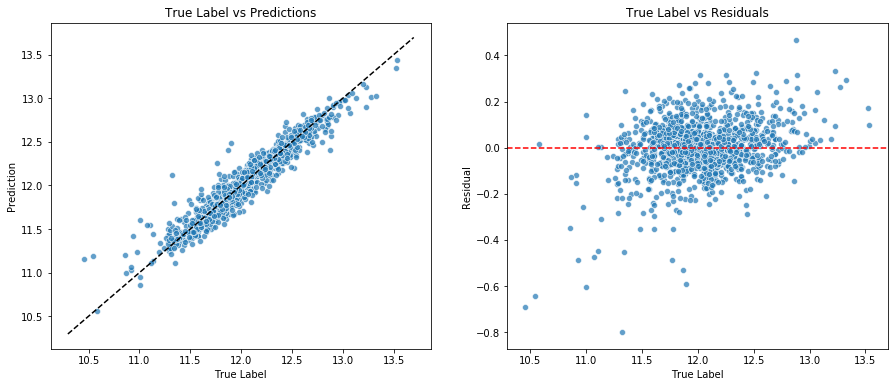

In [73]:
print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(y, ridge_oof)), 4)}')
print(f'Train set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(ridge_oof)), 2)}')
plot_predictions(train_set, y, ridge_oof)

Test set RMSE: 0.1268
Test set MAE: 14592.83


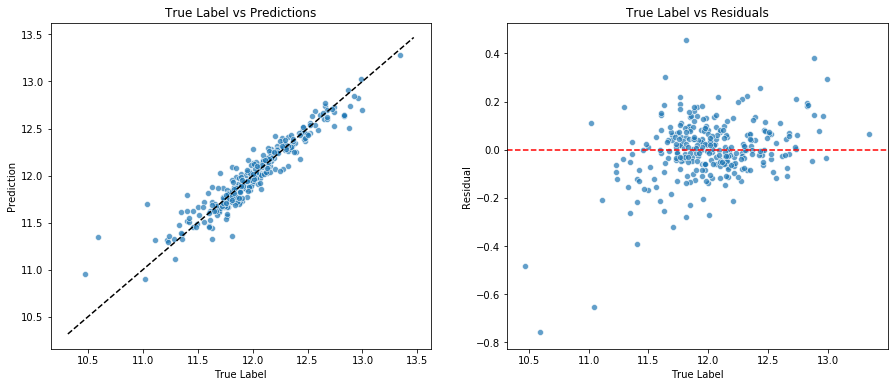

In [74]:
tmp = train_set.copy()
ridge_pipe.fit(tmp, y)
tmp = test_set.copy()
preds = ridge_pipe.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

This time our 2 hours of work (I am considering all the iterations made up until this moment) led to a 12% improvement in RMSE and to a model about 2500 dollars more accurate.

## Tuning RandomForest

The scaler should not matter as in general scaling the data for a tree-based algorithm will only increase the speed and not the outcome.

In [75]:
results.loc[results.model_name=='forest', ]

,model_name,rmse_train,rmse_test,mae_train,mae_test
3,forest,0.022461,0.026503,19452.802373,19297.919206


In [76]:
forest_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_pipe),
                       ('scaler', dfp.df_scaler()),
                       ('dropper', drop_columns()), 
                       ('forest', RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=32))])

* target encoding always helps

In [77]:
forest_params = {'forest__max_depth': [10, 20, 30, None],
                 'forest__max_features': ['auto', 'sqrt', 'log2'], 
                 'forest__min_samples_leaf': [1, 3, 5, 10],
                 'forest__min_samples_split': [2, 4, 6, 8],
                'proc__cat__dummies__drop_first': [True, False],
                'proc__cat__ord__include_extra': ['include', 'dummies'], 
                'proc__num__transf__SF_room': [True, False], 
                'proc__num__transf__bath': [True, False], 
                'proc__num__transf__bedroom': [True, False], 
                'proc__num__transf__lot': [True, False], 
                'proc__num__transf__service': [True, False]}

In [78]:
result_forest, bp_forest, best_forest = grid_search(train_set, y, forest_pipe, 
                                                 param_grid=forest_params, cv=folds, scoring='neg_mean_squared_error', 
                                                 random=100)

In [79]:
result_forest.head(10)

,param_proc__num__transf__service,param_proc__num__transf__lot,param_proc__num__transf__bedroom,param_proc__num__transf__bath,param_proc__num__transf__SF_room,param_proc__cat__ord__include_extra,param_proc__cat__dummies__drop_first,param_forest__min_samples_split,param_forest__min_samples_leaf,param_forest__max_features,param_forest__max_depth,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,False,False,False,True,False,include,True,2,1,sqrt,20,-0.018011,0.002361,0.891282,0.062694,0.292423,0.037982
1,False,False,True,True,False,include,False,6,1,sqrt,20,-0.018148,0.002372,1.046776,0.116357,0.281190,0.046682
2,True,False,True,True,True,include,True,2,1,log2,20,-0.018397,0.002403,0.943161,0.101689,0.290251,0.082073
3,True,True,False,False,False,include,False,6,1,sqrt,None,-0.018486,0.002329,0.865733,0.116569,0.240264,0.012352
4,True,False,False,False,False,include,True,2,1,log2,20,-0.018510,0.001963,0.829536,0.060300,0.238368,0.018504
5,True,True,True,False,True,dummies,True,2,1,sqrt,30,-0.018542,0.002299,0.972040,0.080462,0.229027,0.012038
6,False,False,True,False,False,include,False,2,1,sqrt,None,-0.018633,0.002604,0.903037,0.029227,0.258673,0.018185
7,False,True,False,True,False,include,False,8,1,sqrt,None,-0.018636,0.002488,0.831110,0.060157,0.281380,0.054913
8,True,False,True,True,False,include,True,4,3,sqrt,20,-0.018779,0.002525,0.843420,0.104752,0.308471,0.042207
9,True,False,True,False,True,include,False,2,1,sqrt,10,-0.018849,0.002374,0.921315,0.093660,0.281646,0.038161


In [80]:
bp_forest

{'proc__num__transf__service': False,
 'proc__num__transf__lot': False,
 'proc__num__transf__bedroom': False,
 'proc__num__transf__bath': True,
 'proc__num__transf__SF_room': False,
 'proc__cat__ord__include_extra': 'include',
 'proc__cat__dummies__drop_first': True,
 'forest__min_samples_split': 2,
 'forest__min_samples_leaf': 1,
 'forest__max_features': 'sqrt',
 'forest__max_depth': 20}

In [81]:
get_feature_importance(best_forest)

,feat,score
31,OverallQual,0.131157
40,GrLivArea,0.101533
4,Neighborhood,0.097981
54,total_bath,0.053975
37,TotalBsmtSF,0.050400
5,ExterQual,0.048495
46,GarageArea,0.045904
45,GarageCars,0.045323
33,YearBuilt,0.044733
11,KitchenQual,0.042131


In [82]:
numeric_forest = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(SF_room=False,
                                               bedroom=False, 
                                               lot=False))])


cat_forest = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_forest = dfp.FeatureUnion_df(transformer_list=[('cat', cat_forest),
                                                 ('num', numeric_forest)])

forest_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_forest),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(forest=True)), 
                       ('forest', RandomForestRegressor(n_estimators=1500, max_depth=30, 
                                                        max_features='sqrt',
                                                        n_jobs=-1, random_state=32))])

In [83]:
forest_oof, coefs = cv_score(train_set, y, folds, forest_pipe, imp_coef=True)

coefs

,mean,std
feat,,
OverallQual,0.126223,0.003465
GrLivArea,0.099629,0.002279
service_area,0.093436,0.005467
Neighborhood,0.088920,0.004597
ExterQual,0.062097,0.007247
KitchenQual,0.052535,0.004180
total_bath,0.051098,0.009564
1stFlrSF,0.043344,0.002397
YearBuilt,0.042006,0.003627


Train set RMSE: 0.132
Train set MAE: 16505.39


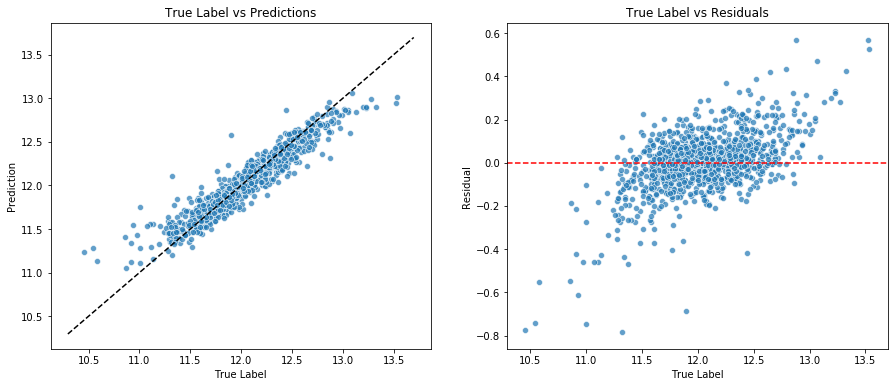

In [84]:
print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(y, forest_oof)), 4)}')
print(f'Train set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(forest_oof)), 2)}')
plot_predictions(train_set, y, forest_oof)

Test set RMSE: 0.1435
Test set MAE: 16144.64


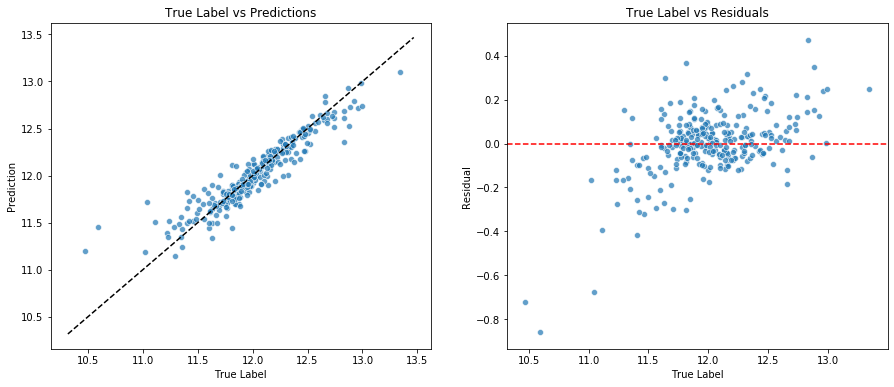

In [85]:
tmp = train_set.copy()
forest_pipe.fit(tmp, y)
tmp = test_set.copy()
preds = forest_pipe.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

Once again, the iterations led to a 12% improvement for RMSE and to a model 3000 dollars more accurate. While the result is worse, the tuning took also very little time (almost completely run time).

## Tuning XGBoost

The strategy here will be a little different as we want to make use of early stopping and tune the other hyperparameters. For some reasons, running the grid_search function above here on Kaggle, is resulting in an endless run. Luckily it is not the case locally and we can tune some of the hyperparameters following this method.

However, the most important hyperparameters to tune are arguably the learning rate and the number of estimators. We thus implement a simple method to make use of the early stopping rounds.

In [86]:
results[results.model_name == 'xgb']

,model_name,rmse_train,rmse_test,mae_train,mae_test
8,xgb,0.0214,0.022856,19263.11387,17771.682631


In [87]:
xgb_pipe = Pipeline([('gen_cl', general_cleaner()),
                     ('proc', processing_pipe),
                     ('scaler', dfp.df_scaler(method='robust')),
                     ('dropper', drop_columns()),
                     ('xgb', xgb.XGBRegressor(n_estimators=2000, objective='reg:squarederror',
                                              max_depth=3, colsample_bytree=0.7, subsample=0.8,
                                              learning_rate=0.05, n_jobs=-1, random_state=31))])

In [88]:
xgb_params = {'xgb__reg_alpha': np.arange(0,1,0.1), 
            'xgb__reg_lambda': np.arange(0,1,0.1),
              'xgb__gamma': np.arange(0,1,0.1),
            'proc__cat__dummies__drop_first': [True, False],
            'proc__cat__ord__include_extra': ['include', 'dummies'], 
            'proc__num__transf__SF_room': [True, False], 
            'proc__num__transf__bedroom': [True, False], 
            'proc__num__transf__lot': [True, False], 
            'proc__num__transf__service': [True, False]}

In [92]:
result_xgb, bp_xgb, best_xgb = grid_search(train_set, y, xgb_pipe,
                                           param_grid=xgb_params, cv=folds, scoring='neg_mean_squared_error',
                                           random=200)

/home/lucabasa/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [93]:
result_xgb.head(10)

,param_xgb__reg_lambda,param_xgb__reg_alpha,param_xgb__gamma,param_proc__num__transf__service,param_proc__num__transf__lot,param_proc__num__transf__bedroom,param_proc__num__transf__SF_room,param_proc__cat__ord__include_extra,param_proc__cat__dummies__drop_first,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0,0.1,0,False,False,False,False,include,True,-0.014868,0.001119,2.476963,0.006902,0.168318,0.003201
1,0.2,0.6,0,False,True,True,False,include,False,-0.014923,0.000993,2.959693,0.136706,0.187427,0.021763
2,0.4,0.6,0,False,False,False,True,include,False,-0.015002,0.001334,2.932979,0.084601,0.196593,0.019905
3,0.5,0.9,0,False,True,True,False,dummies,True,-0.015018,0.001139,2.580617,0.065720,0.170943,0.009310
4,0.4,0.9,0,True,False,False,False,dummies,False,-0.015031,0.001534,2.700683,0.068763,0.165197,0.005924
5,0,0.1,0,False,False,True,False,include,False,-0.015067,0.001631,2.738051,0.056351,0.172159,0.003144
6,0.5,0.5,0,False,True,True,True,dummies,True,-0.015071,0.001037,2.793868,0.154500,0.171648,0.009187
7,0.6,0.3,0,True,True,True,False,dummies,True,-0.015090,0.001219,2.498876,0.022258,0.160556,0.001526
8,0.7,0.8,0,True,False,False,False,include,False,-0.015151,0.001373,2.617057,0.026024,0.170812,0.002970
9,0.6,0.4,0,False,False,False,True,include,True,-0.015156,0.001113,2.547664,0.007363,0.170291,0.002496


In [94]:
bp_xgb

{'xgb__reg_lambda': 0.0,
 'xgb__reg_alpha': 0.1,
 'xgb__gamma': 0.0,
 'proc__num__transf__service': False,
 'proc__num__transf__lot': False,
 'proc__num__transf__bedroom': False,
 'proc__num__transf__SF_room': False,
 'proc__cat__ord__include_extra': 'include',
 'proc__cat__dummies__drop_first': True}

In [95]:
get_feature_importance(best_xgb)

,feat,score
31,OverallQual,0.340732
5,ExterQual,0.168695
4,Neighborhood,0.082502
11,KitchenQual,0.077443
45,GarageCars,0.052772
54,total_bath,0.050564
22,CentralAir_Y,0.042063
40,GrLivArea,0.034191
43,Fireplaces,0.020145
32,OverallCond,0.010302


fold n°0
[0]	validation_0-rmse:11.3983
Will train until validation_0-rmse hasn't improved in 200 rounds.


/home/lucabasa/Git/kaggle_competitions/houseprice/hp/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2000]	validation_0-rmse:0.12975
Stopping. Best iteration:
[2791]	validation_0-rmse:0.128473

fold n°1
[0]	validation_0-rmse:11.4422
Will train until validation_0-rmse hasn't improved in 200 rounds.


/home/lucabasa/Git/kaggle_competitions/houseprice/hp/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2000]	validation_0-rmse:0.12777
[4000]	validation_0-rmse:0.124689
Stopping. Best iteration:
[3988]	validation_0-rmse:0.124681

fold n°2
[0]	validation_0-rmse:11.4132
Will train until validation_0-rmse hasn't improved in 200 rounds.


/home/lucabasa/Git/kaggle_competitions/houseprice/hp/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[1040]	validation_0-rmse:0.112325

fold n°3
[0]	validation_0-rmse:11.4184
Will train until validation_0-rmse hasn't improved in 200 rounds.


/home/lucabasa/Git/kaggle_competitions/houseprice/hp/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[1693]	validation_0-rmse:0.113101

fold n°4
[0]	validation_0-rmse:11.4176
Will train until validation_0-rmse hasn't improved in 200 rounds.


/home/lucabasa/Git/kaggle_competitions/houseprice/hp/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2000]	validation_0-rmse:0.114826
Stopping. Best iteration:
[2021]	validation_0-rmse:0.114735

CV score: 0.11887 
Test set RMSE: 0.1189
Test set MAE: 15163.0


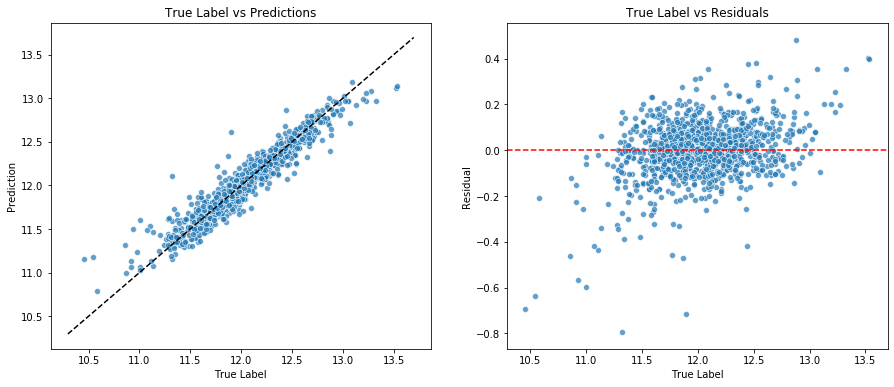

In [89]:
numeric_xgb = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(bedroom=False, 
                                               lot=False))])


cat_xgb = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_xgb = dfp.FeatureUnion_df(transformer_list=[('cat', cat_xgb),
                                                 ('num', numeric_xgb)])

xgb_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_xgb),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(xgb=True))])

def xgb_train(train, target, pipe, kfolds):

    oof = np.zeros(len(train))
    pd.options.mode.chained_assignment = None 
    
    feat_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(kfolds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = train.iloc[trn_idx].copy()
        val_data = train.iloc[val_idx].copy()
        
        trn_target = target.iloc[trn_idx]
        val_target = target.iloc[val_idx]
        
        trn_data = pipe.fit_transform(trn_data, trn_target)
        val_data = pipe.transform(val_data)
    
        clf = xgb.XGBRegressor(n_estimators=10000, objective='reg:squarederror',
                               max_depth=3, colsample_bytree=0.5, subsample=0.5,
                               reg_alpha=0.4, reg_lambda=0.6,
                               learning_rate=0.01, n_jobs=-1, random_state=31).fit(
            trn_data, trn_target,
            eval_set=[(val_data, val_target)], 
            eval_metric='rmse', early_stopping_rounds=200, verbose=2000)
        
        oof[val_idx] = clf.predict(pipe.transform(train.iloc[val_idx]),
                                   ntree_limit=clf.best_iteration)
        
        fold_df = pd.DataFrame()
        fold_df["feat"] = trn_data.columns
        fold_df["score"] = clf.feature_importances_     
        fold_df['fold'] = fold_ + 1
        feat_df = pd.concat([feat_df, fold_df], axis=0)
       

    feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
    feat_df['abs_sco'] = (abs(feat_df['mean']))
    feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
    del feat_df['abs_sco']

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    pd.options.mode.chained_assignment = 'warn'
    
    return oof, feat_df


tmp = train_set.copy()


oof_xgb, f_i = xgb_train(tmp, y, xgb_pipe, folds)

print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y, oof_xgb)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(oof_xgb)), 2)}')
plot_predictions(train_set, y, oof_xgb)

In [90]:
f_i

,mean,std
feat,,
OverallQual,0.135794,0.010028
KitchenQual,0.072979,0.012236
GrLivArea,0.071382,0.007811
total_bath,0.067101,0.006452
service_area,0.064675,0.010547
Neighborhood,0.061331,0.005926
ExterQual,0.056205,0.006257
Fireplaces,0.054507,0.008905
CentralAir_Y,0.054118,0.009709


# Tune LightGBM

In [101]:
results[results.model_name == 'lgb']

,model_name,rmse_train,rmse_test,mae_train,mae_test
8,lgb,0.022145,0.023838,19300.519951,17652.136542


In [102]:
lgb_pipe = Pipeline([('gen_cl', general_cleaner()),
                     ('proc', processing_pipe),
                     ('scaler', dfp.df_scaler(method='robust')),
                     ('dropper', drop_columns()),
                     ('lgb', lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, 
                                               num_leaves=50, max_depth=3, 
                                               subsample=0.8, colsample_bytree=1.0))])

In [103]:
lgb_params = {'lgb__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
              'lgb__num_leaves': [10, 30, 50, 70, 100, 120, 150],
              'lgb__subsample': [1, 0.9, 0.8, 0.5],
              'lgb__colsample_bytree': [1, 0.8, 0.7, 0.5],
                'proc__cat__dummies__drop_first': [True], 
                'proc__num__transf__bedroom': [True, False], 
                'proc__num__transf__lot': [True, False], 
                'scaler__method': ['standard', 'robust']}

In [104]:
result_lgb, bp_lgb, best_lgb = grid_search(train_set, y, lgb_pipe,
                                           param_grid=lgb_params, cv=folds, scoring='neg_mean_squared_error',
                                           random=200)

In [105]:
result_lgb.head(10)

,param_scaler__method,param_proc__num__transf__lot,param_proc__num__transf__bedroom,param_proc__cat__dummies__drop_first,param_lgb__subsample,param_lgb__num_leaves,param_lgb__n_estimators,param_lgb__colsample_bytree,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,standard,False,False,True,0.8,10,450,0.5,-0.015000,0.001358,0.427065,0.029437,0.189010,0.014381
1,standard,False,False,True,1,120,450,0.5,-0.015000,0.001358,0.412815,0.010848,0.173600,0.004235
2,standard,False,False,True,0.9,70,450,0.5,-0.015000,0.001358,0.411024,0.014610,0.177621,0.005797
3,standard,False,False,True,1,100,250,0.5,-0.015023,0.001678,0.403996,0.048293,0.191987,0.018973
4,standard,False,False,True,1,30,400,0.5,-0.015038,0.001393,0.394231,0.007529,0.195129,0.018021
5,standard,False,False,True,1,150,200,0.5,-0.015066,0.001818,0.353815,0.007934,0.179301,0.016559
6,standard,False,False,True,0.8,120,200,0.5,-0.015066,0.001818,0.350969,0.008225,0.179091,0.011480
7,standard,True,False,True,0.8,100,450,0.5,-0.015179,0.001193,0.495164,0.036125,0.193331,0.020357
8,standard,True,False,True,1,50,450,0.5,-0.015179,0.001193,0.403163,0.015658,0.184059,0.009169
9,robust,True,False,True,1,30,450,0.5,-0.015207,0.001274,0.504894,0.062570,0.198437,0.010794


In [106]:
bp_lgb

{'scaler__method': 'standard',
 'proc__num__transf__lot': False,
 'proc__num__transf__bedroom': False,
 'proc__cat__dummies__drop_first': True,
 'lgb__subsample': 1,
 'lgb__num_leaves': 120,
 'lgb__n_estimators': 450,
 'lgb__colsample_bytree': 0.5}

In [107]:
get_feature_importance(best_lgb)

,feat,score
30,LotArea,235
36,BsmtUnfSF,196
54,service_area,195
39,GrLivArea,166
43,GarageYrBlt,135
37,1stFlrSF,123
32,OverallCond,122
33,YearBuilt,116
4,Neighborhood,110
29,LotFrontage,97


Test set RMSE: 0.1281
Test set MAE: 14678.48


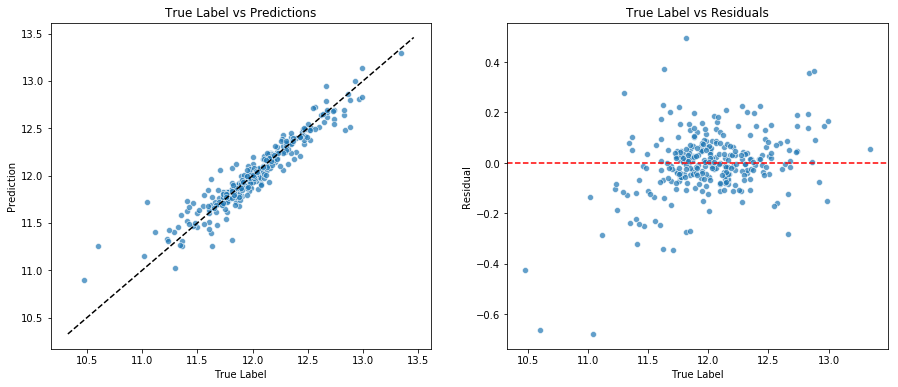

In [108]:
tmp = test_set.copy()
preds = best_lgb.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

fold n°0
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 0.133179
[2000]	valid_0's rmse: 0.129403
[3000]	valid_0's rmse: 0.127145
[4000]	valid_0's rmse: 0.126104
[5000]	valid_0's rmse: 0.125755
Early stopping, best iteration is:
[5499]	valid_0's rmse: 0.125556
fold n°1
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 0.132177
[2000]	valid_0's rmse: 0.127854
[3000]	valid_0's rmse: 0.126728
[4000]	valid_0's rmse: 0.12628
Early stopping, best iteration is:
[4204]	valid_0's rmse: 0.126021
fold n°2
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 0.115877
Early stopping, best iteration is:
[1077]	valid_0's rmse: 0.115781
fold n°3
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse: 0.118081
Early stopping, best iteration is:
[989]	valid_0's rmse: 0.118008
fold n°4
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's rmse:

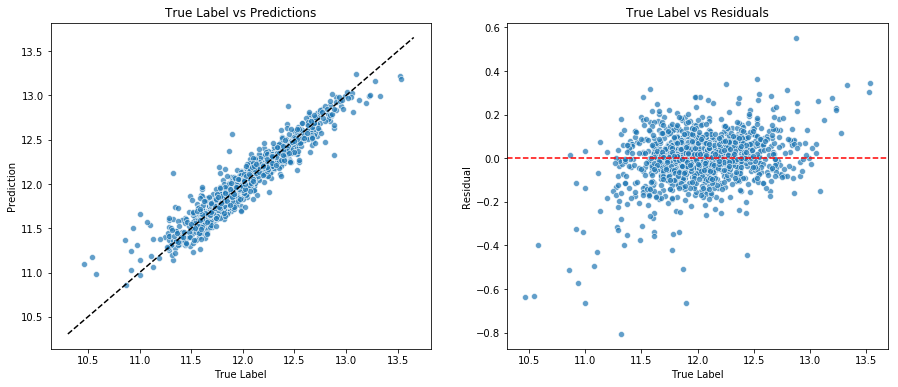

In [110]:
numeric_lgb = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(bedroom=False,
                                               SF_room=False,
                                               lot=False))])


cat_lgb = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_lgb = dfp.FeatureUnion_df(transformer_list=[('cat', cat_lgb),
                                                 ('num', numeric_lgb)])

lgb_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_lgb),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(lgb=True))])

def lgb_train(train, target, pipe, kfolds):

    oof = np.zeros(len(train))
    pd.options.mode.chained_assignment = None 
    
    feat_df = pd.DataFrame()
    
    for fold_, (trn_idx, val_idx) in enumerate(kfolds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = train.iloc[trn_idx].copy()
        val_data = train.iloc[val_idx].copy()
        
        trn_target = target.iloc[trn_idx]
        val_target = target.iloc[val_idx]
        
        trn_data = pipe.fit_transform(trn_data, trn_target)
        val_data = pipe.transform(val_data)
    
        clf = lgb.LGBMRegressor(n_estimators=20000, learning_rate=0.01,
                                num_leaves=4, max_depth=3,
                                subsample=0.8, colsample_bytree=0.5).fit(
            trn_data, trn_target,
            eval_set=[(val_data, val_target)], 
            eval_metric='rmse', early_stopping_rounds=200, verbose=1000)
        
        oof[val_idx] = clf.predict(pipe.transform(train.iloc[val_idx]),
                                   ntree_limit=clf.best_iteration_)
        
        fold_df = pd.DataFrame()
        fold_df["feat"] = trn_data.columns
        fold_df["score"] = clf.feature_importances_    
        fold_df['fold'] = fold_ + 1
        feat_df = pd.concat([feat_df, fold_df], axis=0)
       

    feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
    feat_df['abs_sco'] = (abs(feat_df['mean']))
    feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
    del feat_df['abs_sco']

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    pd.options.mode.chained_assignment = 'warn'
    
    return oof, feat_df


tmp = train_set.copy()


oof_lgb, f_i = lgb_train(tmp, y, lgb_pipe, folds)

print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y, oof_lgb)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(oof_lgb)), 2)}')
plot_predictions(train_set, y, oof_lgb)

In [111]:
f_i['prop'] = f_i['std'] / f_i['mean'] * 100

f_i.sort_values('prop', ascending=False)

,mean,std,prop
feat,,,
BldgType_TwnhsE,1.4,3.130495,223.606798
Alley,1.6,3.577709,223.606798
BedroomAbvGr,39.6,62.111191,156.846441
BldgType_Duplex,26.0,39.242834,150.933976
MasVnrType_None,18.6,26.959228,144.942089
LandContour,25.6,36.773632,143.646999
MSZoning_RM,55.4,76.271227,137.673694
MasVnrType_Stone,17.2,22.851696,132.858696
GarageType_Detchd,26.4,34.896991,132.185573


In [115]:
train_set['lasso_oof'] = lasso_oof
train_set['ridge_oof'] = ridge_oof
train_set['forest_oof'] = forest_oof
train_set['xgb_oof'] = oof_xgb
train_set['lgb_oof'] = oof_lgb
train_set['target'] = y

train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lasso_oof,ridge_oof,forest_oof,xgb_oof,lgb_oof,target
1231,1233,90,RL,70.0,9842,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,1Story,4,5,1962,1962,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,Y,SBrkr,1224,0,0,1224,0,0,2,0,2,2,TA,6,Typ,0,NaN,CarPort,1962.0,Unf,2,462,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,11.555853,11.573088,11.655304,11.600304,11.571178,11.530775
1456,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.846610,11.844509,11.805784,11.860367,11.855860,11.864469
242,243,50,RM,63.0,5000,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,4,1900,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,540,540,GasA,Gd,N,FuseA,889,551,0,1440,0,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1940.0,Unf,1,352,Fa,TA,Y,0,0,77,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal,11.459496,11.436707,11.589603,11.441122,11.410178,11.277216
93,94,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,6,1910,1998,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Rec,1046,Unf,0,168,1214,GasW,Ex,N,SBrkr,1260,1031,0,2291,0,1,2,0,4,2,TA,9,Typ,1,Gd,Detchd,1900.0,Unf,2,506,TA,TA,Y,0,0,0,0,99,0,NaN,NaN,NaN,0,11,2007,WD,Normal,12.077764,12.076719,12.012558,12.025039,12.047149,11.804856
1268,1270,50,RL,78.0,11344,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1.5Fin,5,5,1958,1958,Gable,CompShg,MetalSd,MetalSd,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,BLQ,460,Unf,0,414,874,GasW,TA,Y,FuseA,874,650,0,1524,0,0,1,1,3,1,TA,7,Typ,0,NaN,Attchd,1958.0,Unf,1,315,TA,TA,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,7,2007,WD,Normal,11.754415,11.729797,11.830394,11.807817,11.826274,11.877576


In [116]:
train_set.to_csv('../oof_pred/for_error_analysis.csv', index=False)

### To be continued. Thank your reading this unfinished notebook, please feel free to ask for clarification or suggest other things I should cover in the next sections (even if most of them are already planned)

In [98]:
df_test = pd.read_csv('../data/test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [99]:
def make_sub(df_test, prediction, filename):
    sub = df_test[['Id']].copy()
    sub['SalePrice'] = prediction
    sub.to_csv('../submissions/'+filename, index=False)

In [100]:
tmp = df_test.copy()
preds = best_xgb.predict(tmp)
preds = np.expm1(preds)
make_sub(df_test, preds, 'xgb.csv')

In [101]:
tmp = df_train.copy()
y = tmp['target'].copy()
del tmp['target']
best_xgb.fit(tmp, y)
tmp = df_test.copy()
preds = best_xgb.predict(tmp)
preds = np.expm1(preds)
make_sub(df_test, preds, 'xgb_all.csv')

/home/lucabasa/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
